Within this notebook we will outline all of the methods and the results.

The layout will be different to the actual document as we can discuss the methods then directly apply them and view the immediate results.

# Data

First we import the data and the required libraries. The data is in a feather format generated from a database api that connects to a MySQL database and downloads the data into a feather format after utilising an object storage method to clean the data.

In [2]:
# We import some libraries and read in the data
from carbon_converter import *
from data import *
from graph import multihist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import rpy2.ipython.html

df = pd.read_feather('df.feather')


We set some entries to zero that are decimal numbers in integer fields.

We also limit the dataset to vineyards that are over 100m^2.

Finally we set a couple of entries for average price per tonne to nan as they recorded only $1 per tonne.

We drop a single value who has recorded water used at 4 orders of magnitude higher than those before them and is not a larger vineyard.

We also remove entries who have no GI Region.

In [3]:
df.loc[
    (df["insecticide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["insecticide_spraying_number_of_times_passes_per_year"]!=0)
    , "insecticide_spraying_number_of_times_passes_per_year"] = 0

df.loc[
    (df["herbicide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["herbicide_spraying_number_of_times_passes_per_year"]!=0)
    , "herbicide_spraying_number_of_times_passes_per_year"] = 0

# Too small, a fly out the window
for id in df[df['area_harvested']<1].index:
    df = df.drop(index=id)

# 1$ values for price
df.loc[1848, "average_per_tonne"] = np.nan
df.loc[5493, "average_per_tonne"] = np.nan

# Ridiculous water use
#df = df.drop(5112)

# no giregion
df = df.drop(df[df["giregion"] == "0"].index)

print()


We remove two outliers. These are interesting outliers as they are examples of what not to do. At first glance they appear to be seemingly normal vineyards, but become outliers due to their size. As one of them is a smaller vineyard they have used an excessive amount of fuel, likely because of inefficiently doing trips around the vineyards for single purposes. This behaviour does not scale up what so ever.

In [4]:
#df = df.drop(5642)
#df = df.drop(4642)

The data requires a bit of amalgamation for certain fields, specifically we calculate the total fertiliser/nitrogen, water, and fuel used. This is a simple summation.

We also calculate the total emissions of a vineyard using scope 1 and scope 2 emissions for the different fuels and electricity used. This was done using the Australian National Greenhouse Accounts Factors

In [5]:
# TODO
# add nitrogen/fertiliser added together in data pipeline
df['nitrogen_applied'] = df['synthetic_nitrogen_applied']+df['organic_nitrogen_applied']
df['fertiliser_applied'] = df['synthetic_fertiliser_applied']+df['organic_fertiliser_applied']

df["fertiliser"] = df['fertiliser_applied'] + df['nitrogen_applied']

# We convert the use of fuels into CO2E
# This includes both scope1 and scope 2 in the totals, as well as separate columns for comparison.
df["total_irrigation_electricity"] = df["total_irrigation_electricity"].apply(scope2)
df["irrigation_energy_diesel"] = df["irrigation_energy_diesel"].apply(diesel_irrigation)
df["irrigation_energy_electricity"] = df["irrigation_energy_electricity"].apply(scope2)
df["irrigation_energy_pressure"] = df["irrigation_energy_pressure"].apply(scope2)
df["diesel_vineyard"] = df["diesel_vineyard"].apply(diesel_vehicle)
df["electricity_vineyard"] = df["electricity_vineyard"].apply(scope2)
df["petrol_vineyard"] = df["petrol_vineyard"].apply(petrol_vehicle)
df["lpg_vineyard"] = df["lpg_vineyard"].apply(lpg_vehicle)
df["biodiesel_vineyard"] = df["biodiesel_vineyard"].apply(biodiesel_vehicle)

df["scope2"] = df["total_irrigation_electricity"]\
    + df["irrigation_energy_electricity"]\
    + df["irrigation_energy_pressure"]\
    + df["electricity_vineyard"]

df["scope1"] = df["irrigation_energy_diesel"]\
    + df["diesel_vineyard"]\
    + df["petrol_vineyard"]\
    + df["lpg_vineyard"]\
    + df["biodiesel_vineyard"]

df["total_emissions"] = df["scope1"] + df["scope2"]


The data set is limitted to samples who have recorded area, eidl, water used, and emissions.

In [6]:
# we limit it to recordings for the baseline variables.

df = df.replace({0: np.nan})
df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_vineyard_fuel"].notnull())]
#df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_emissions"].notnull())]



In [7]:
# We make some lists for ease of use

cont_var = [
    "water_used"
    , "tonnes_grapes_harvested"
    , "total_vineyard_fuel"
    , "total_vineyard_electricity"
    , "fertiliser"
]

feature_list = [
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "total_tractor_passes"
    , "slashing_number_of_times_passes_per_year"
    , "fungicide_spraying_number_of_times_passes_per_year"
    , "herbicide_spraying_number_of_times_passes_per_year"
    , "insecticide_spraying_number_of_times_passes_per_year"
    , "fertiliser"
    , "total_emissions"
]

We have a look at the sparsity of particular variables. The list below shows the percentage of each variables response rates.

In [8]:
total = len(df)
print("n = {}".format(total))
print("Proportion of entries in each column:\n")
for feature in feature_list:
    entries = len(df[df[feature].notnull()][feature])
    print("{}: {} | {}%".format(feature, entries, round((entries/total)*100, 2)))

n = 5375
Proportion of entries in each column:

area_harvested: 5375 | 100.0%
tonnes_grapes_harvested: 5375 | 100.0%
water_used: 5375 | 100.0%
total_tractor_passes: 1971 | 36.67%
slashing_number_of_times_passes_per_year: 1932 | 35.94%
fungicide_spraying_number_of_times_passes_per_year: 1917 | 35.67%
herbicide_spraying_number_of_times_passes_per_year: 1732 | 32.22%
insecticide_spraying_number_of_times_passes_per_year: 931 | 17.32%
fertiliser: 709 | 13.19%
total_emissions: 5375 | 100.0%


In [10]:
len(df["giregion"].unique())

57

In [19]:
len(df["member_id"].unique())

1287

In [11]:
total = len(df[df["average_per_tonne"].notnull()])

n = 891
Proportion of entries in each column:

area_harvested: 5375 | 603.25%
tonnes_grapes_harvested: 5375 | 603.25%
water_used: 5375 | 603.25%
total_tractor_passes: 1971 | 221.21%
slashing_number_of_times_passes_per_year: 1932 | 216.84%
fungicide_spraying_number_of_times_passes_per_year: 1917 | 215.15%
herbicide_spraying_number_of_times_passes_per_year: 1732 | 194.39%
insecticide_spraying_number_of_times_passes_per_year: 931 | 104.49%
fertiliser: 709 | 79.57%
total_emissions: 5375 | 603.25%


In [17]:
len(df.loc[df["average_per_tonne"].notnull(), "giregion"].unique())

45

In [18]:
len(df.loc[df["average_per_tonne"].notnull(), "member_id"].unique())

475

In [16]:
df.loc[df["average_per_tonne"].notnull(), "data_year_id"].unique()

array(['2020/2021', '2021/2022', '2019/2020', '2018/2019'], dtype=object)

### We look at the proportion of entries for each region:

In [245]:
total = len(df)
print("n = {}".format(total))
print("number of regions is {}".format(len(df["giregion"].unique())))
print("Proportion of entries in each column:\n")
for region in df["giregion"].unique():
    entries = len(df[df["giregion"]==region]["giregion"])
    print("{}: {} | {}%".format(region, entries, round((entries/total)*100, 2)))

n = 5623
number of regions is 57
Proportion of entries in each column:

Barossa Valley: 542 | 9.64%
Padthaway: 194 | 3.45%
Hunter Valley: 57 | 1.01%
Coonawarra: 276 | 4.91%
Rutherglen: 31 | 0.55%
Langhorne Creek: 335 | 5.96%
Clare Valley: 134 | 2.38%
Riverland: 454 | 8.07%
Murray Darling: 504 | 8.96%
Upper Goulburn: 20 | 0.36%
Swan Hill: 82 | 1.46%
Adelaide Hills: 424 | 7.54%
Bendigo: 52 | 0.92%
Grampians: 71 | 1.26%
Henty: 21 | 0.37%
Mount Benson: 18 | 0.32%
Wrattonbully: 184 | 3.27%
Robe: 36 | 0.64%
Currency Creek: 23 | 0.41%
Southern Fleurieu: 29 | 0.52%
McLaren Vale: 1094 | 19.46%
Yarra Valley: 109 | 1.94%
Margaret River: 312 | 5.55%
Blackwood Valley: 9 | 0.16%
Glenrowan: 4 | 0.07%
Riverina: 18 | 0.32%
Eden Valley: 90 | 1.6%
Other: 18 | 0.32%
Big Rivers Zone Other: 9 | 0.16%
Heathcote: 29 | 0.52%
Orange: 52 | 0.92%
Kangaroo Island: 10 | 0.18%
Cowra: 6 | 0.11%
Mornington Peninsula: 30 | 0.53%
Adelaide Plains: 25 | 0.44%
Mount Gambier: 10 | 0.18%
Southern Flinders Ranges: 19 | 0.34%


In [11]:
df.groupby("giregion")["member_id"].count().describe()

count      57.000000
mean       94.298246
std       179.986206
min         1.000000
25%         9.000000
50%        20.000000
75%        82.000000
max      1025.000000
Name: member_id, dtype: float64

In [12]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values
region_selection = list(region_selection).append("other")

### How do the variables correlate to each other

In [13]:
df[feature_list].corr().style.background_gradient(cmap='coolwarm')

In [14]:
(1+df[cont_var]).apply(np.log).div(df["area_harvested"], axis=0).corr().style.background_gradient(cmap='coolwarm')

### How are the varaible distributed

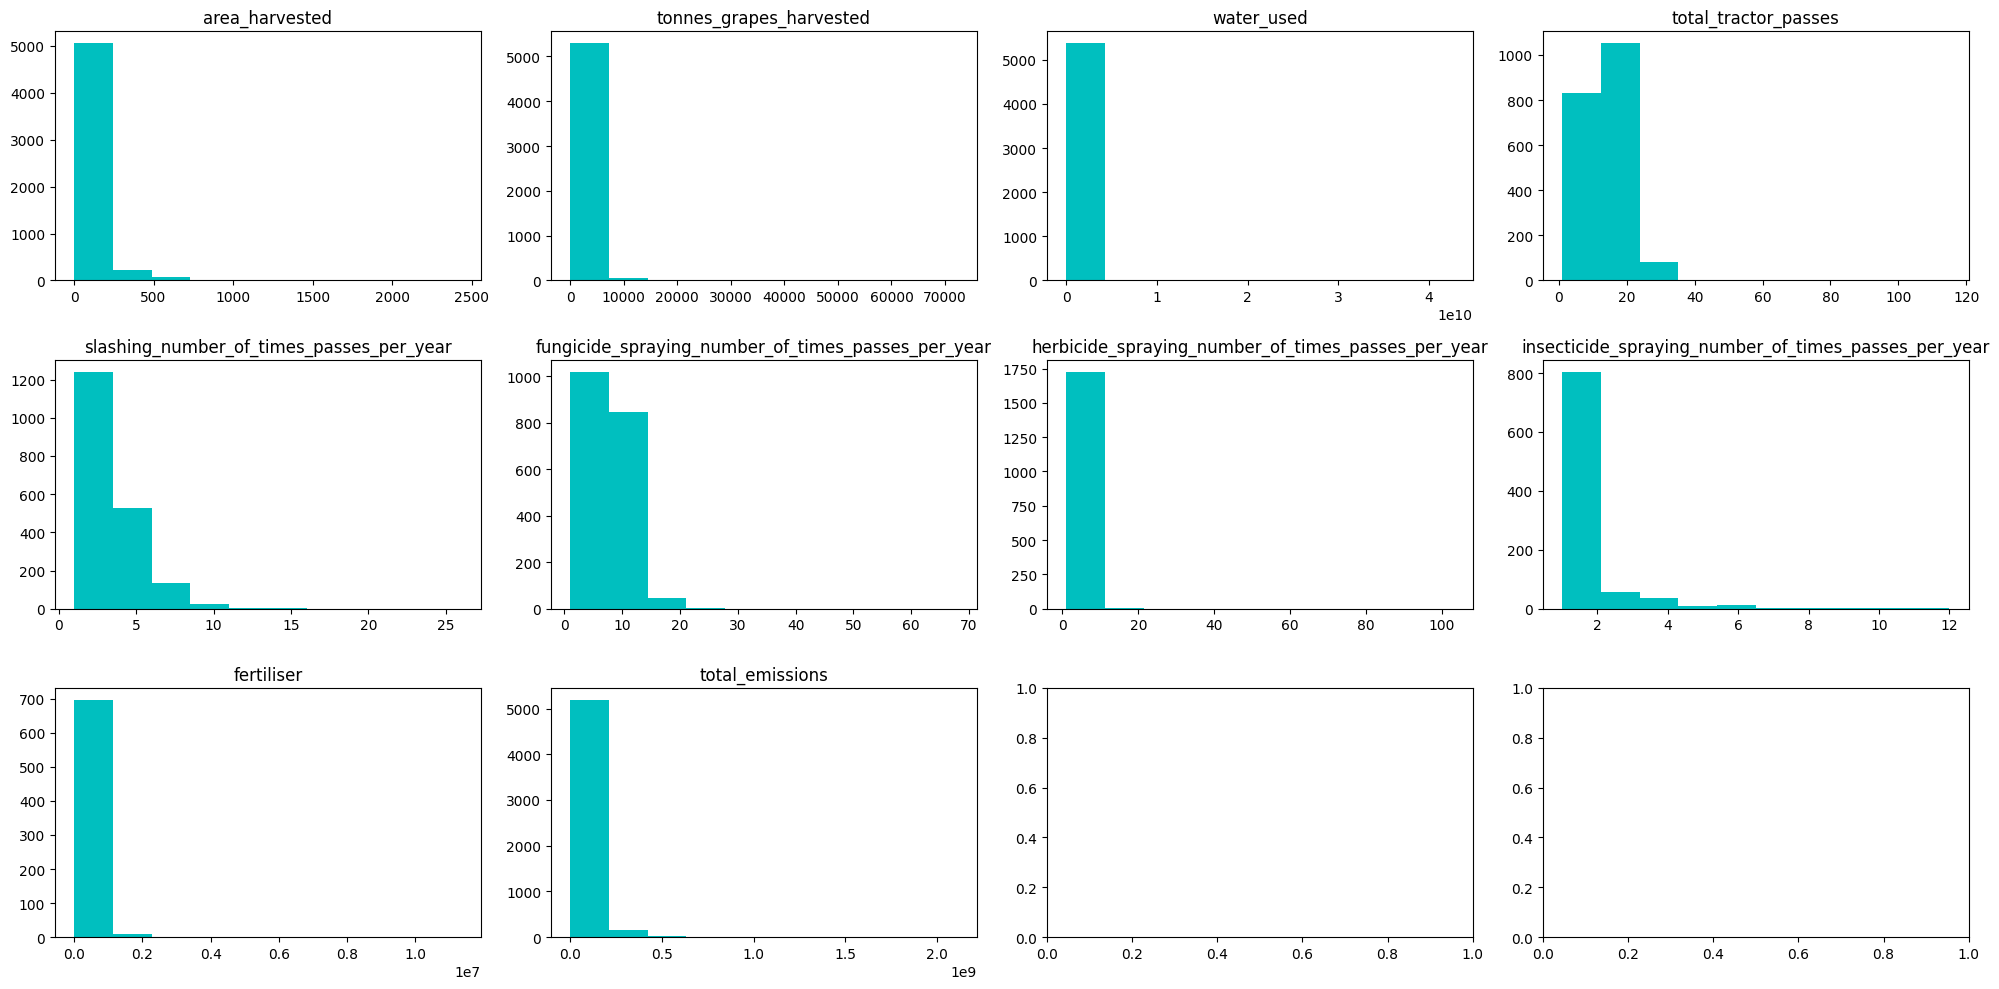

In [15]:
multihist(df[feature_list])
plt.tight_layout()

There are notably two problems with this data. It is skewed due to there being more smalelr wineries than larger, and that there are a few outliers that are likely due to user error. We remove the top and bottom ends and this fixes it.

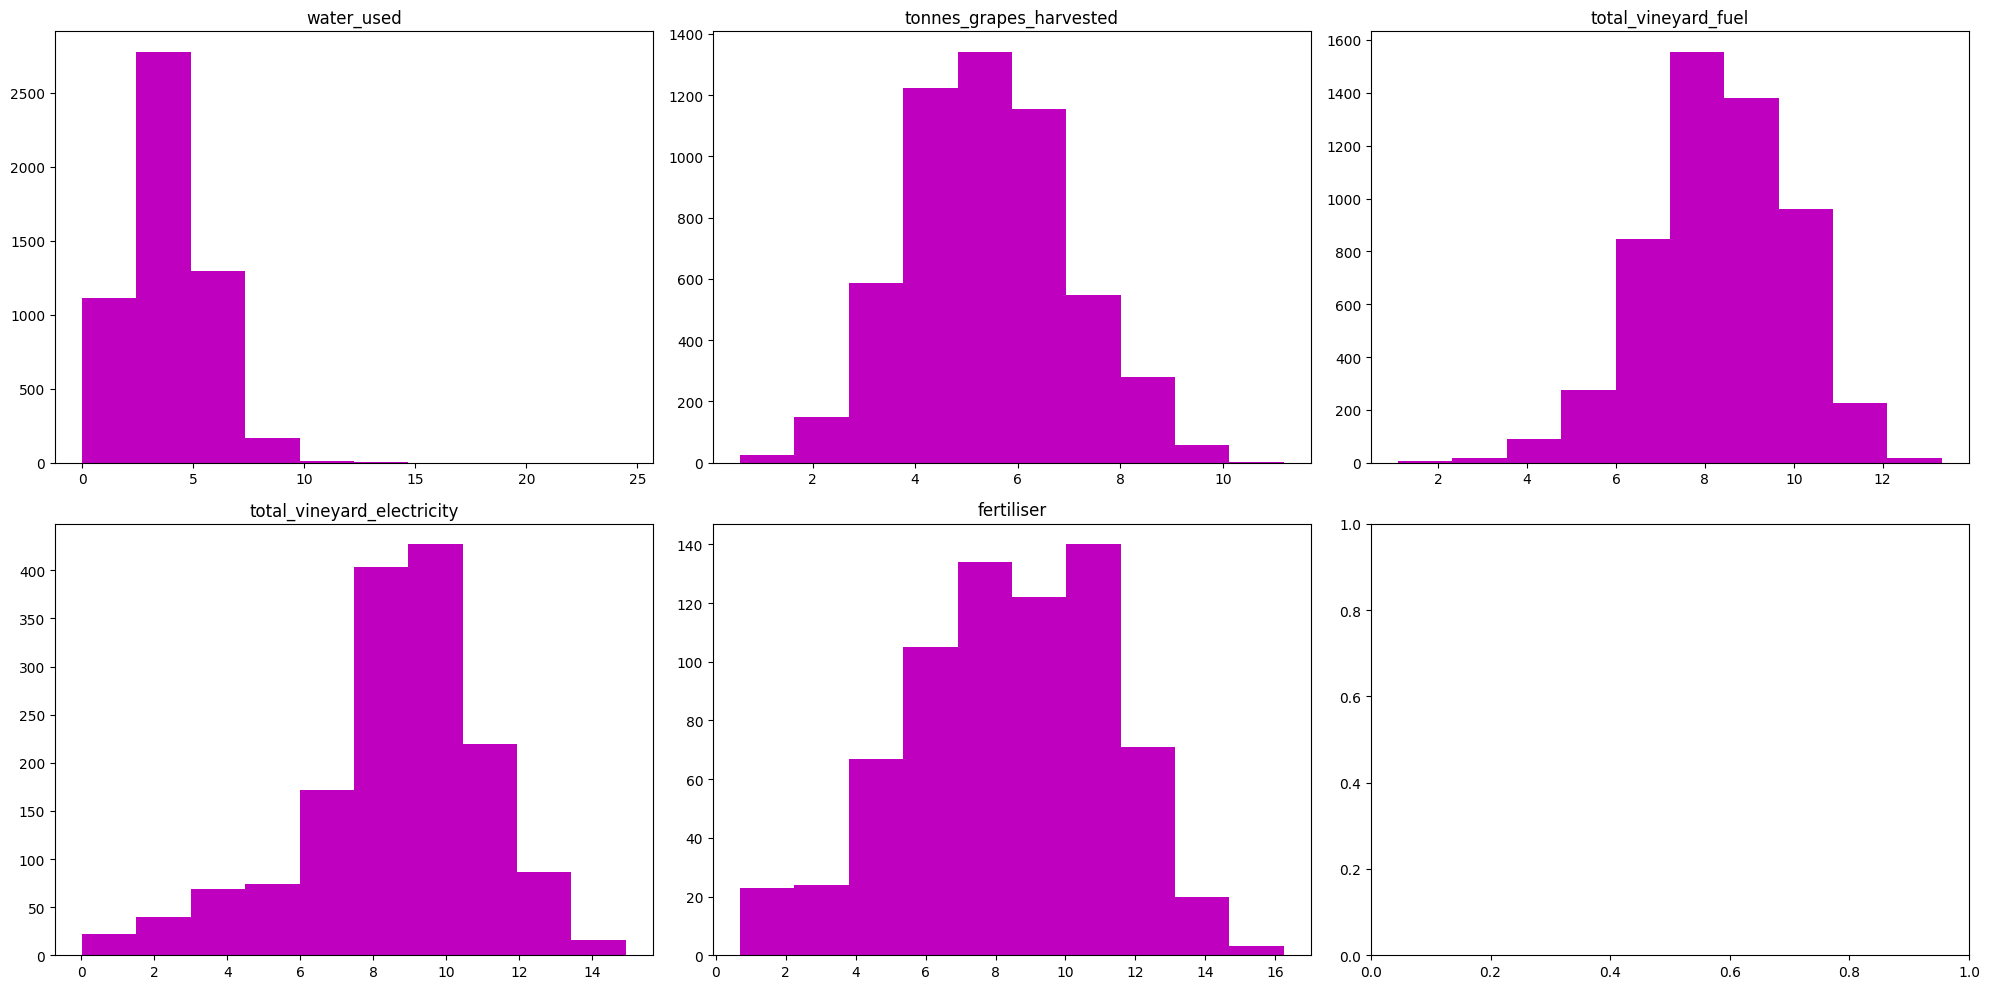

In [16]:
#If values graphed below are overwhelming large then a random error has occurred. Rerun the cell until the dissapear.
fig, ax = multihist((1+df[cont_var]).apply(np.log), color="m")
plt.tight_layout()

### GLM Baseline

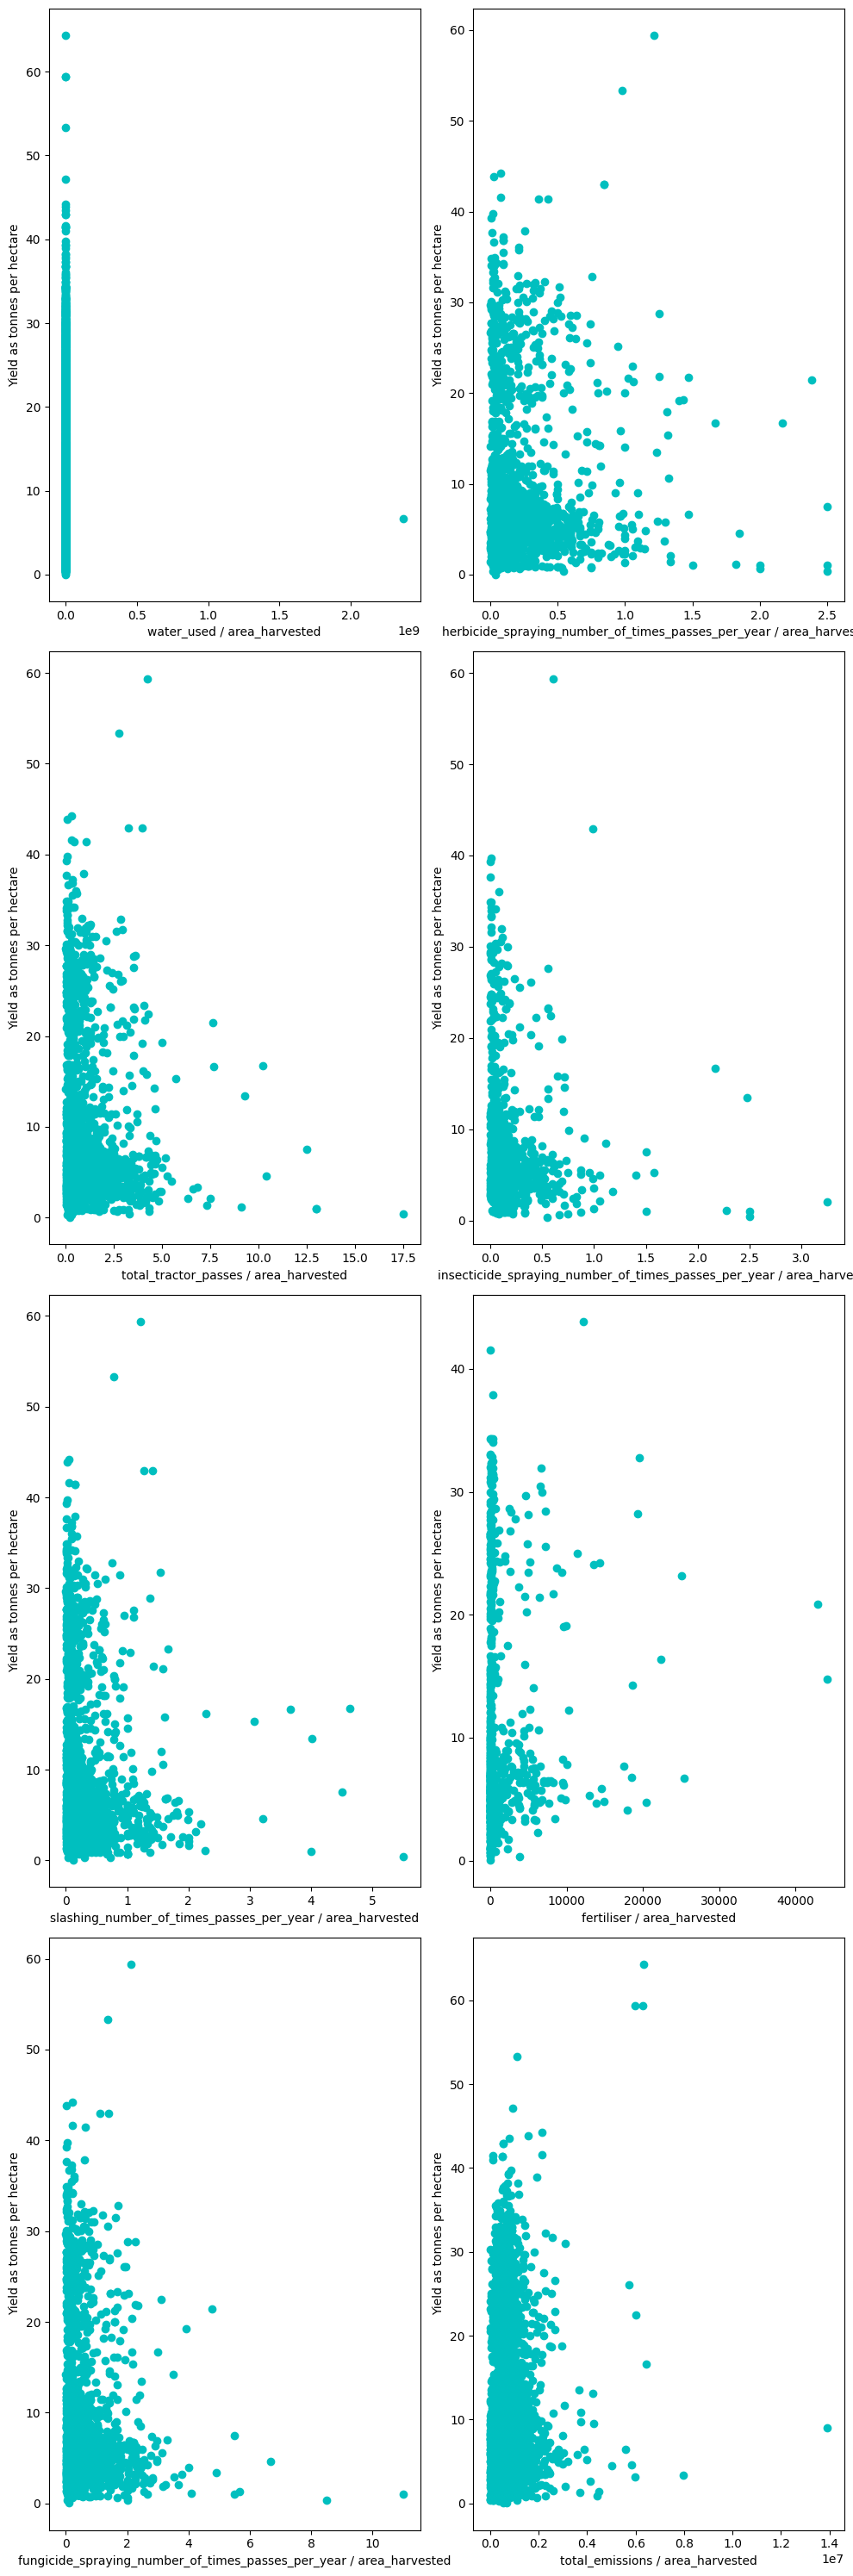

In [17]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j = 0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue
    ax[i][j].scatter((1+df[feature]).div(1 + df["area_harvested"]),
                  df['tonnes_grapes_harvested'].div(1+df["area_harvested"]), color="c")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0

#fig.text(-0.01, 0.5, "Yield as tonnes per hectare", va="center", rotation='vertical')
fig.tight_layout()
plt.show()

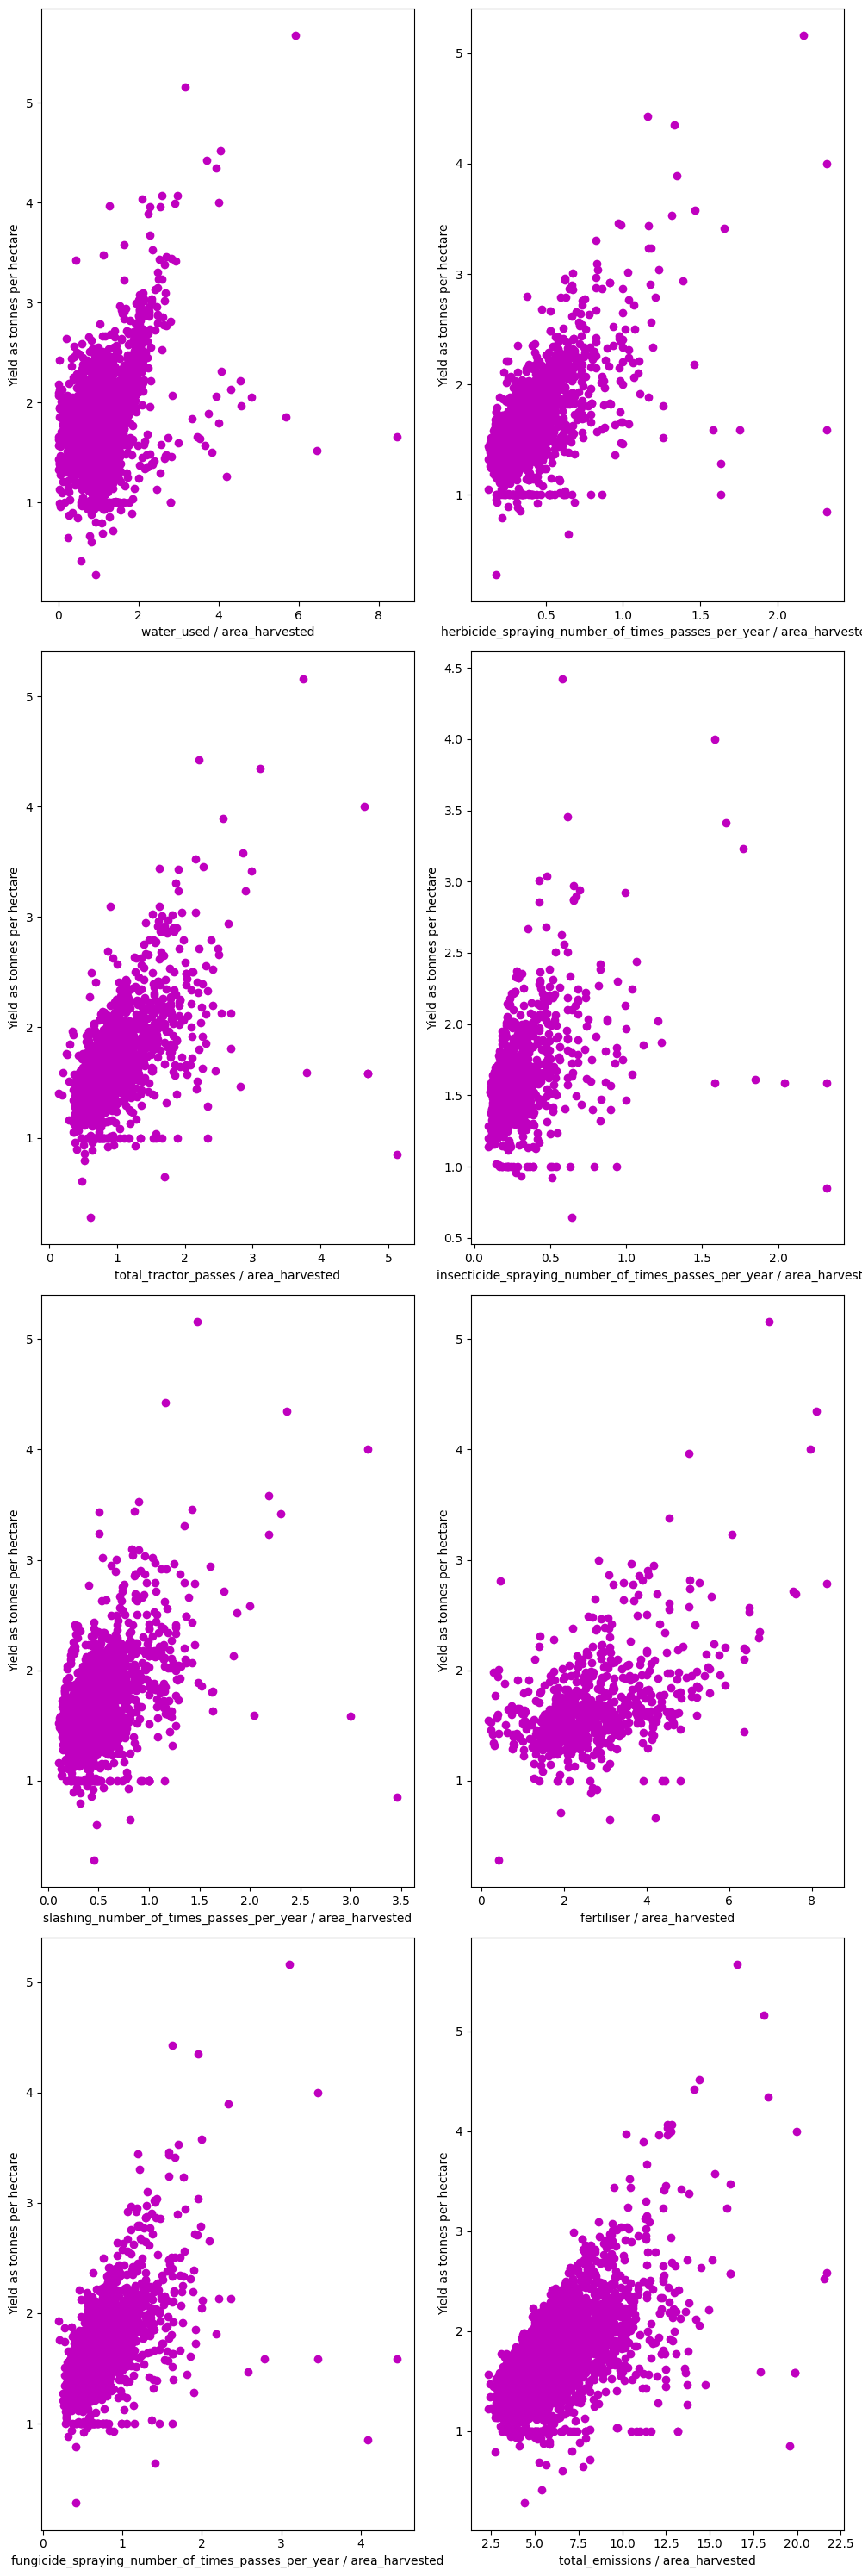

In [18]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j=0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue 
    ax[i][j].scatter(((1+df[feature]).apply(np.log)).div((1+df["area_harvested"]).apply(np.log))
                  , (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
                  , color="m")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0
        
#fig.text(0.04, 0.5, "Yield", ha="center", rotation='vertical')
fig.tight_layout()
plt.show()

In [19]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "(1+df$tonnes_grapes_harvested)/(1+df$area_harvested)"
    "~ (1+df$total_emissions)/(1+df$area_harvested)"
    "+ (1+df$water_used)/(1+df$area_harvested) "
    "+ (df$total_tractor_passes)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ (1+df$fertiliser)/(1+df$area_harvested)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (1 + df$tonnes_grapes_harvested)/(1 + df$area_harvested)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5374
df$total_emissions                                       1   5359.4      5373
df$water_used                                            1      8.6      5372
df$total_tractor_passes                                  1    132.3      5371
df$slashing_number_of_times_passes_per_year              1    789.2      5370
df$fungicide_spraying_number_of_times_passes_per_year    1   1024.6      5369
df$herbicide_spraying_number_of_times_passes_per_year    1   3640.2      5368
df$insecticide_spraying_number_of_times_passes_per_year  1    136.0      5367
df$fertiliser                                            1    497.6      5366
df$total_emiss

<rpy2.robjects.vectors.ListVector object at 0x7f87f98d3440> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f52c7d40> [RTYPES.REALSXP]
R classes: ('numeric',)
[8.900327, 0.000000, -0.000002, -2.708595, ..., 0.000005, -0.000000, 0.000000, -0.000000]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f98f1a40> [RTYPES.REALSXP]
R classes: ('numeric',)
[-4.109688, -5.786313, -5.324283, -3.068032, ..., -3.857139, 22.835668, 11.663710, -4.996560]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f52e9dc0> [RTYPES.REALSXP]
R classes: ('numeric',)
[10.097784, 10.466868, 10.411240, 10.194195, ..., 9.057139, 11.411952, 11.109537, 9.673979]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f9d4d780> [RTYPES.REALSXP]
R classes: ('numeric',)
[-718.345483, -73.207754, -2.940628, 11.500092, ..., -4.018623, 22.732758, 11.628305, -5.205563]
...
<rpy2.robjects.vectors.ListVector object at 0x7f87f98d3440> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f87f98b9480> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f883d7b3480> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f87f98d3440> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [20]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ (df$total_tractor_passes)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ log(df$fertiliser+1)/log(df$area_harvested+1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5374
log(df$total_emissions + 1)                              1  139.652      5373
log(df$water_used + 1)                                   1    5.473      5372
df$total_tractor_passes                                  1    0.747      5371
df$slashing_number_of_times_passes_per_year              1    0.000      5370
df$fungicide_spraying_number_of_times_passes_per_year    1    0.252      5369
df$herbicide_spraying_number_of_times_passes_per_year    1    1.307      5368
df$insecticide_spraying_number_of_times_passes_per_year  1    0.038      5367
log(df$fertiliser + 1)                                   1    0.545      5366
log(df$t

<rpy2.robjects.vectors.ListVector object at 0x7f87f5304a00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f979e140> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.144684, 0.092364, -0.007360, -0.049546, ..., 0.009546, -0.024925, 0.031091, -0.001825]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f507f0c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.047859, -0.108590, -0.055967, 0.008760, ..., 0.154772, 0.141875, 0.147394, -0.084490]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f539b440> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.451797, 1.469483, 1.415710, 1.419547, ..., 1.994052, 1.750269, 1.612021, 1.930039]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f52aec40> [RTYPES.REALSXP]
R classes: ('numeric',)
[-121.939617, 11.817438, 2.339353, 0.864254, ..., 0.153308, 0.145710, 0.145554, -0.081942]
...
<rpy2.robjects.vectors.ListVector object at 0x7f87f5304a00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f87f539e1c0> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f883d7b3480> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f87f5304a00> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [21]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser + 1)/log(df$area_harvested+1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5374
log(df$total_emissions + 1)                             1  139.652      5373
log(df$water_used + 1)                                  1    5.473      5372
log(df$fertiliser + 1)                                  1    0.696      5371
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  135.291      5370
log(df$area_harvested + 1):log(df$water_used + 1)       1   21.110      5369
log(df$area_harvested + 1):log(df$fertiliser + 1)       1    0.256      5368
                                                       Resid. Dev
NULL                                                       714.78
log(df$total_emissions + 1)             

<rpy2.robjects.vectors.ListVector object at 0x7f87f5188980> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87fb99b340> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.154983, 0.091002, -0.005350, 0.009470, -0.024835, 0.030875, -0.001766]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f5188e40> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.046053, -0.106235, -0.053951, 0.008988, ..., 0.155466, 0.159208, 0.153147, -0.072407]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f5196e80> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.449991, 1.467127, 1.413694, 1.419319, ..., 1.993357, 1.732937, 1.606268, 1.917957]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f87f5196180> [RTYPES.REALSXP]
R classes: ('numeric',)
[-121.939617, 11.817438, 2.339353, -0.834377, ..., 0.154128, 0.162026, 0.155131, -0.069408]
...
<rpy2.robjects.vectors.ListVector object at 0x7f87f5188980> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f87f9b2a880> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f883d7b3480> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f87f5188980> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [22]:
rpy2.ipython.html.init_printing()
r = robjects.r

df.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5374
log(df$total_emissions + 1)                             1  139.652      5373
log(df$water_used + 1)                                  1    5.473      5372
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  135.514      5371
log(df$area_harvested + 1):log(df$water_used + 1)       1   21.191      5370
                                                       Resid. Dev
NULL                                                       714.78
log(df$total_emissions + 1)                                575.12
log(df$water_used + 1)                                     569.65
log(df$total_emissions + 1):log(df$area_harvested + 1)     434

In [23]:
rpy2.ipython.html.init_printing()
r = robjects.r

dfr = df[df["total_vineyard_fuel"]>0]

dfr.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "df$tonnes_grapes_harvested"
    "~ df$total_emissions"
    "+ log(df$water_used+1)"
    "+ log(df$area_harvested+1)"
    "+ df$fertiliser"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: df$tonnes_grapes_harvested

Terms added sequentially (first to last)


                           Df   Deviance Resid. Df Resid. Dev
NULL                                           708 9895144467
df$total_emissions          1 7641083156       707 2254061311
log(df$water_used + 1)      1   59335812       706 2194725499
log(df$area_harvested + 1)  1  158511381       705 2036214118
df$fertiliser               1  397317920       704 1638896198

***************
* GLM Summary *


Call:
glm(formula = eval(parse(text = formula)))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-10989.7    -425.0      25.6     413.5   11147.2  

Coefficients:
                                  Estimate      Std. Error t value
(Intercept)                -522.8521961697  186.9371127903  -2.797
df$total_emissions            0.0000217903    0.0000007646  28.498
log(df$water_used + 1)      

In [24]:
model[4]

<rpy2.robjects.vectors.FloatMatrix object at 0x7f87f9c252c0> [RTYPES.REALSXP]
R classes: ('matrix', 'array')
[-26.627054, 0.000000, 0.000000, 0.000000, ..., -8693791.257738, -1287652.887389, 1658509.477589, 10250414.289495]

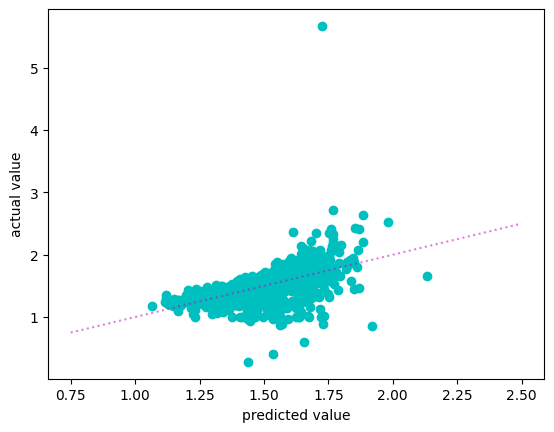

In [246]:
fig, ax = plt.subplots()

plt.plot([0.75,2.5], [0.75,2.5], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

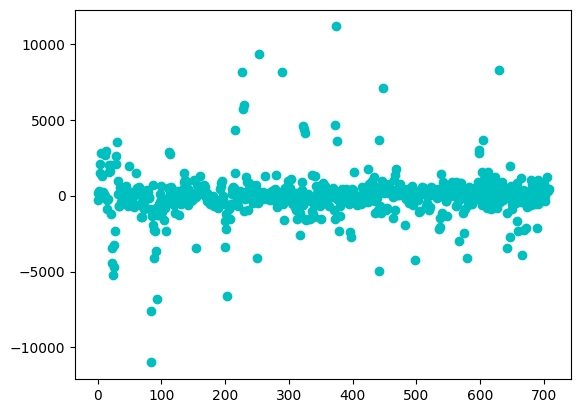

In [26]:
residuals = model[1]
plt.scatter(range(len(residuals)), residuals, color="c")

In [27]:
np.std(np.array(residuals))

1520.3816044499745

In [28]:
np.max(np.array(residuals))

11147.210103567937

In [29]:
np.min(np.array(residuals))

-10989.708077912932

(array([  1.,   0.,   0.,   3.,   0.,   4.,  11.,  15.,  41., 301., 279.,
         29.,   8.,   7.,   2.,   2.,   1.,   3.,   1.,   1.]),
 array([-10989.70807791,  -9882.86216884,  -8776.01625976,  -7669.17035069,
         -6562.32444162,  -5455.47853254,  -4348.63262347,  -3241.78671439,
         -2134.94080532,  -1028.09489625,     78.75101283,   1185.5969219 ,
          2292.44283098,   3399.28874005,   4506.13464912,   5612.9805582 ,
          6719.82646727,   7826.67237635,   8933.51828542,  10040.36419449,
         11147.21010357]),
 <BarContainer object of 20 artists>)

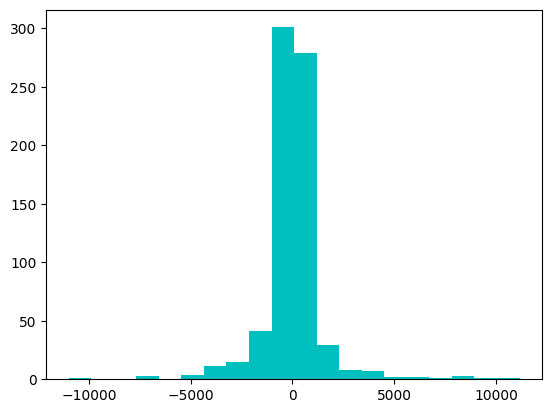

In [30]:
plt.hist(residuals, bins=20, color="c")

In [31]:
from scipy.stats import shapiro

shapiro(residuals)

ShapiroResult(statistic=0.7394593954086304, pvalue=7.138198261575972e-32)

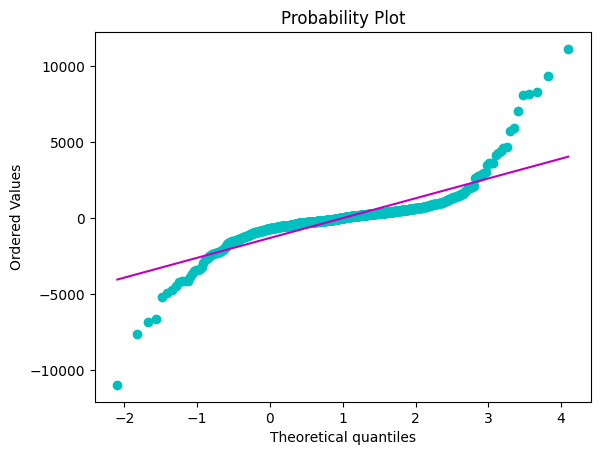

In [32]:
from scipy import stats

fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist='norm'
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [33]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df[feature_list].replace({np.nan: 0}))
for i in range(len(pca.explained_variance_ratio_)):
    print("{}: {}".format(feature_list[i], pca.explained_variance_ratio_[i]))
    print("{}: {}".format(feature_list[i], pca.singular_values_[i]))

area_harvested: 0.9782783948353942
area_harvested: 42676030659.9859
tonnes_grapes_harvested: 0.021721513027872334
tonnes_grapes_harvested: 6359131764.167216
water_used: 9.213046194379496e-08
water_used: 13096474.802257802
total_tractor_passes: 6.261319704931613e-12
total_tractor_passes: 107965.68066820569
slashing_number_of_times_passes_per_year: 9.764364947725282e-15
slashing_number_of_times_passes_per_year: 4263.583657098302
fungicide_spraying_number_of_times_passes_per_year: 2.2121354992571536e-16
fungicide_spraying_number_of_times_passes_per_year: 641.7393202149998
herbicide_spraying_number_of_times_passes_per_year: 8.811195210982443e-18
herbicide_spraying_number_of_times_passes_per_year: 128.07672057428715
insecticide_spraying_number_of_times_passes_per_year: 3.97599928364155e-18
insecticide_spraying_number_of_times_passes_per_year: 86.0351531382415
fertiliser: 1.6886811892894236e-18
fertiliser: 56.06949184957144
total_emissions: 4.932191824289247e-22
total_emissions: 0.9582366265

In [34]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

dfr["water_and_emmissions"] = (1+dfr["water_used"]).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log)) +\
            ((1+dfr["total_emissions"]).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log)))
dfr["yield"] = (1+dfr['tonnes_grapes_harvested']).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log))


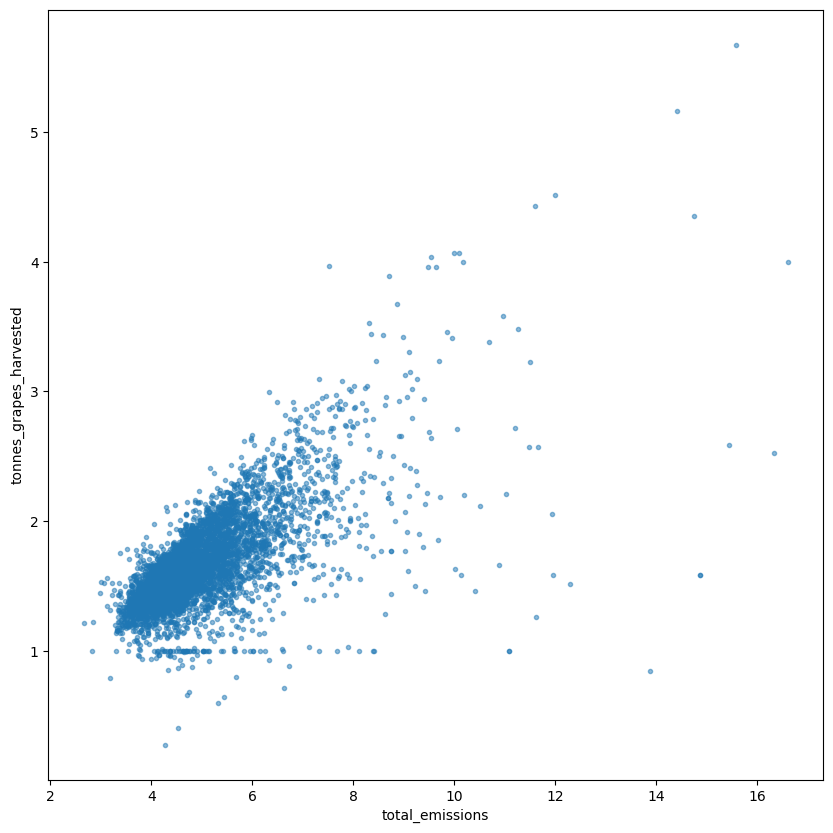

In [247]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    (dfr["water_and_emmissions"])
    , dfr["yield"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

    
plt.show()

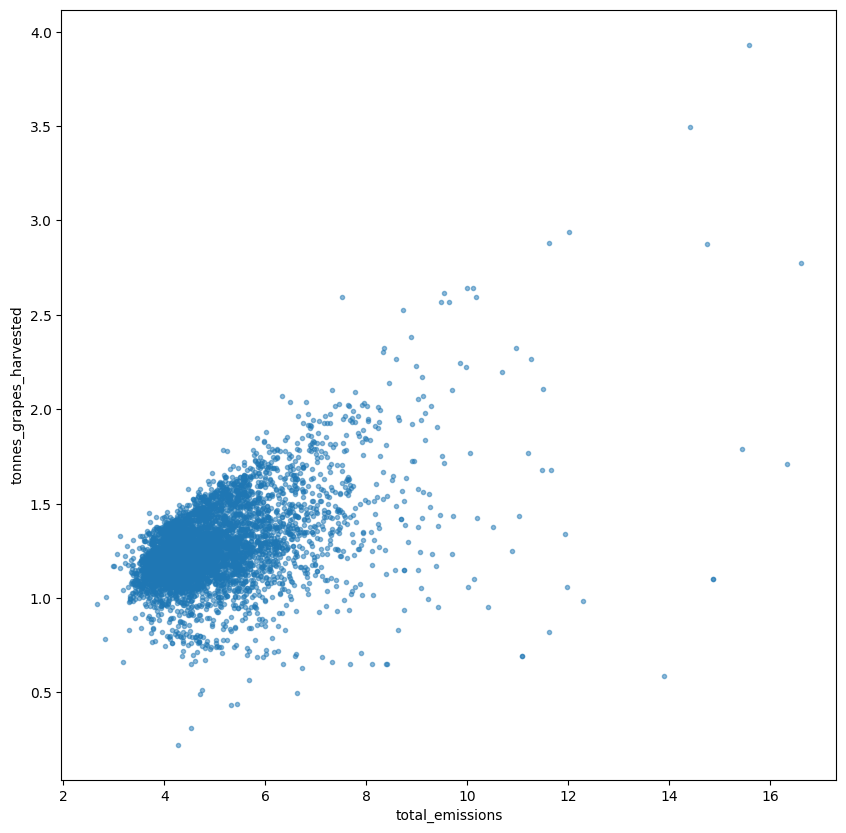

In [36]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div(1+df["area_harvested"].apply(np.log)) +\
    (1+df["total_emissions"]).apply(np.log).div(1+df["area_harvested"].apply(np.log))

#df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
#    ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))

#df["water_and_emmissions"] = ((1+df["total_emissions"]).div(df["area_harvested"]) + (1+df["water_used"]).div(df["area_harvested"])).apply(np.log)

fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    (df["water_and_emmissions"])
    , ((1+df["tonnes_grapes_harvested"])).apply(np.log).div(1+df["area_harvested"].apply(np.log))
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

plt.show()

In [37]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

region_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(region_selection))))

for i in range(len(region_selection)):
   region_color[region_selection[i]] = i = next(color)

df['colors'] = df[df["giregion"].isin(region_selection)]["giregion"].apply(lambda x: region_color[x])

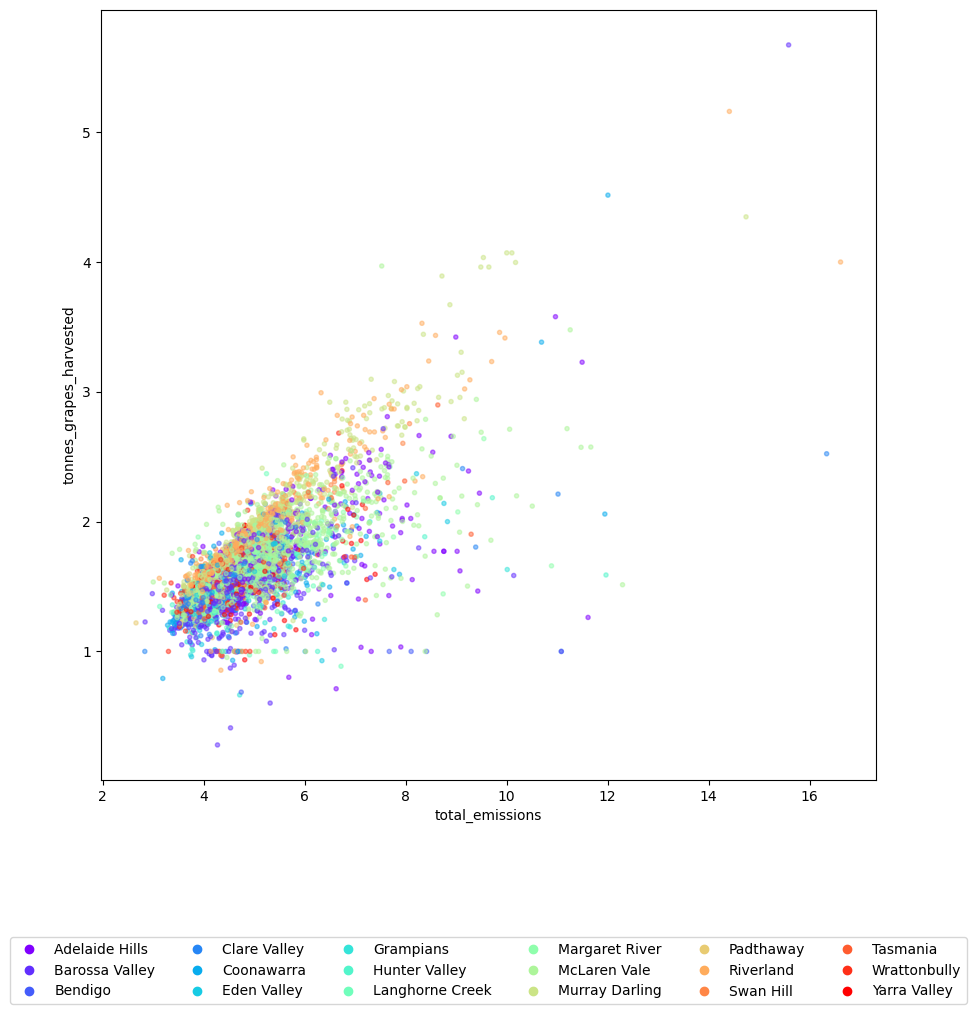

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df[df["giregion"].isin(region_selection)]["water_and_emmissions"],
    df[df["giregion"].isin(region_selection)]['yield'],
    c=df[df["giregion"].isin(region_selection)]["colors"]
    , label=df["giregion"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

In [39]:
import matplotlib.cm as cm

year_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(df["data_year_id"].unique()))))

for i in range(len(df["data_year_id"].unique())):
   year_color[df["data_year_id"].unique()[i]] = i = next(color)

df['ycolors'] = df["data_year_id"].apply(lambda x: year_color[x])

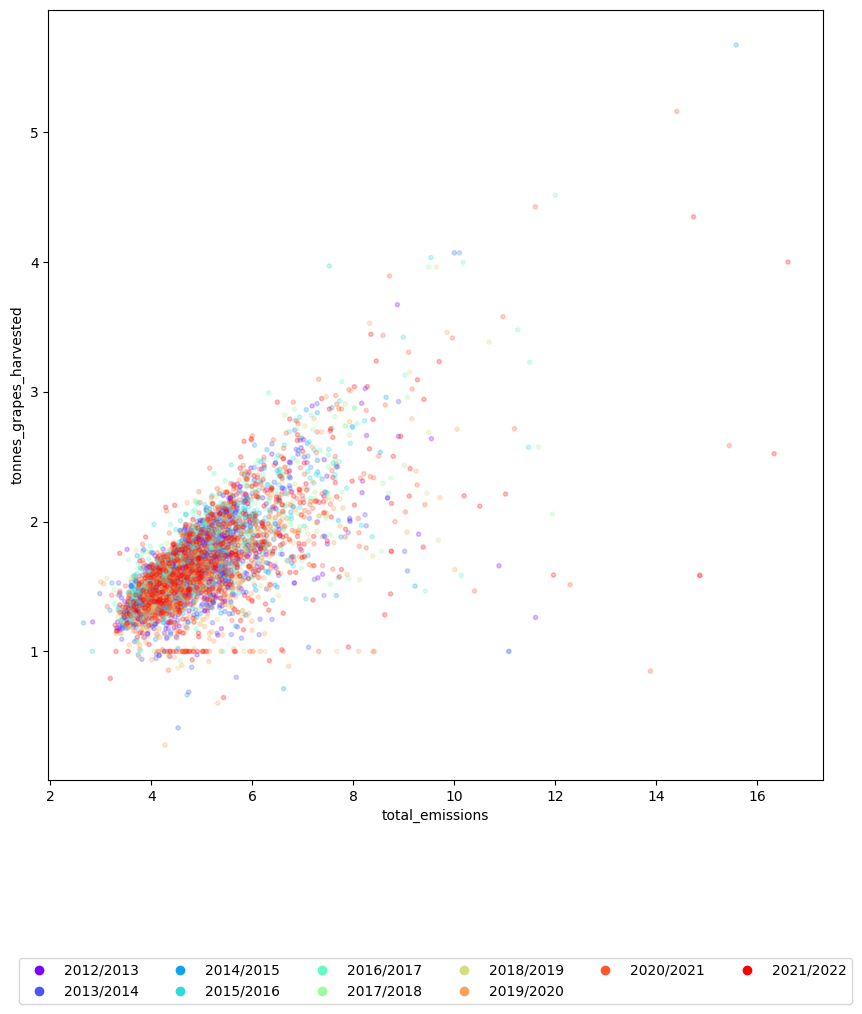

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield'],
    c=df["ycolors"]
    , label=df["data_year_id"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in year_color.values()]
plt.legend(markers, year_color, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

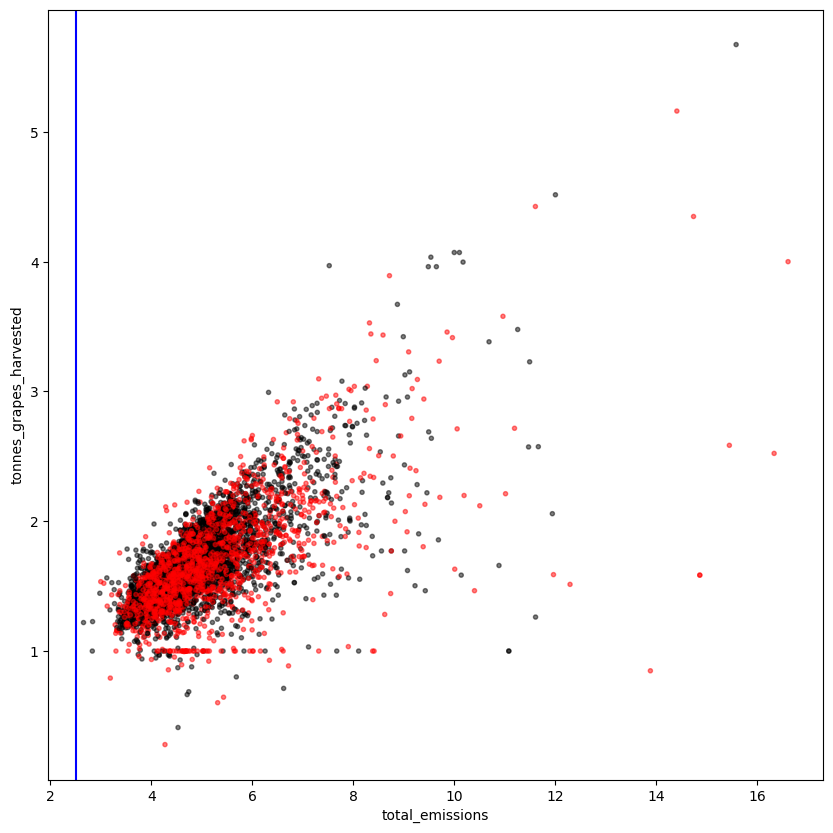

In [41]:
df.loc[df["total_tractor_passes"]>0, "contractors"] = "Yes"
df.loc[df["total_tractor_passes"]==0, "contractors"] = "No"
df.loc[df["total_tractor_passes"].isnull(), "contractors"] = "null"

fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df["water_and_emmissions"]
    , df['yield']
    , c=df["contractors"].replace({"Yes": "red", "No": "blue", "null": "black"})
    , label=df["contractors"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.axvline(x = 2.5, color = 'b')
    
plt.show()

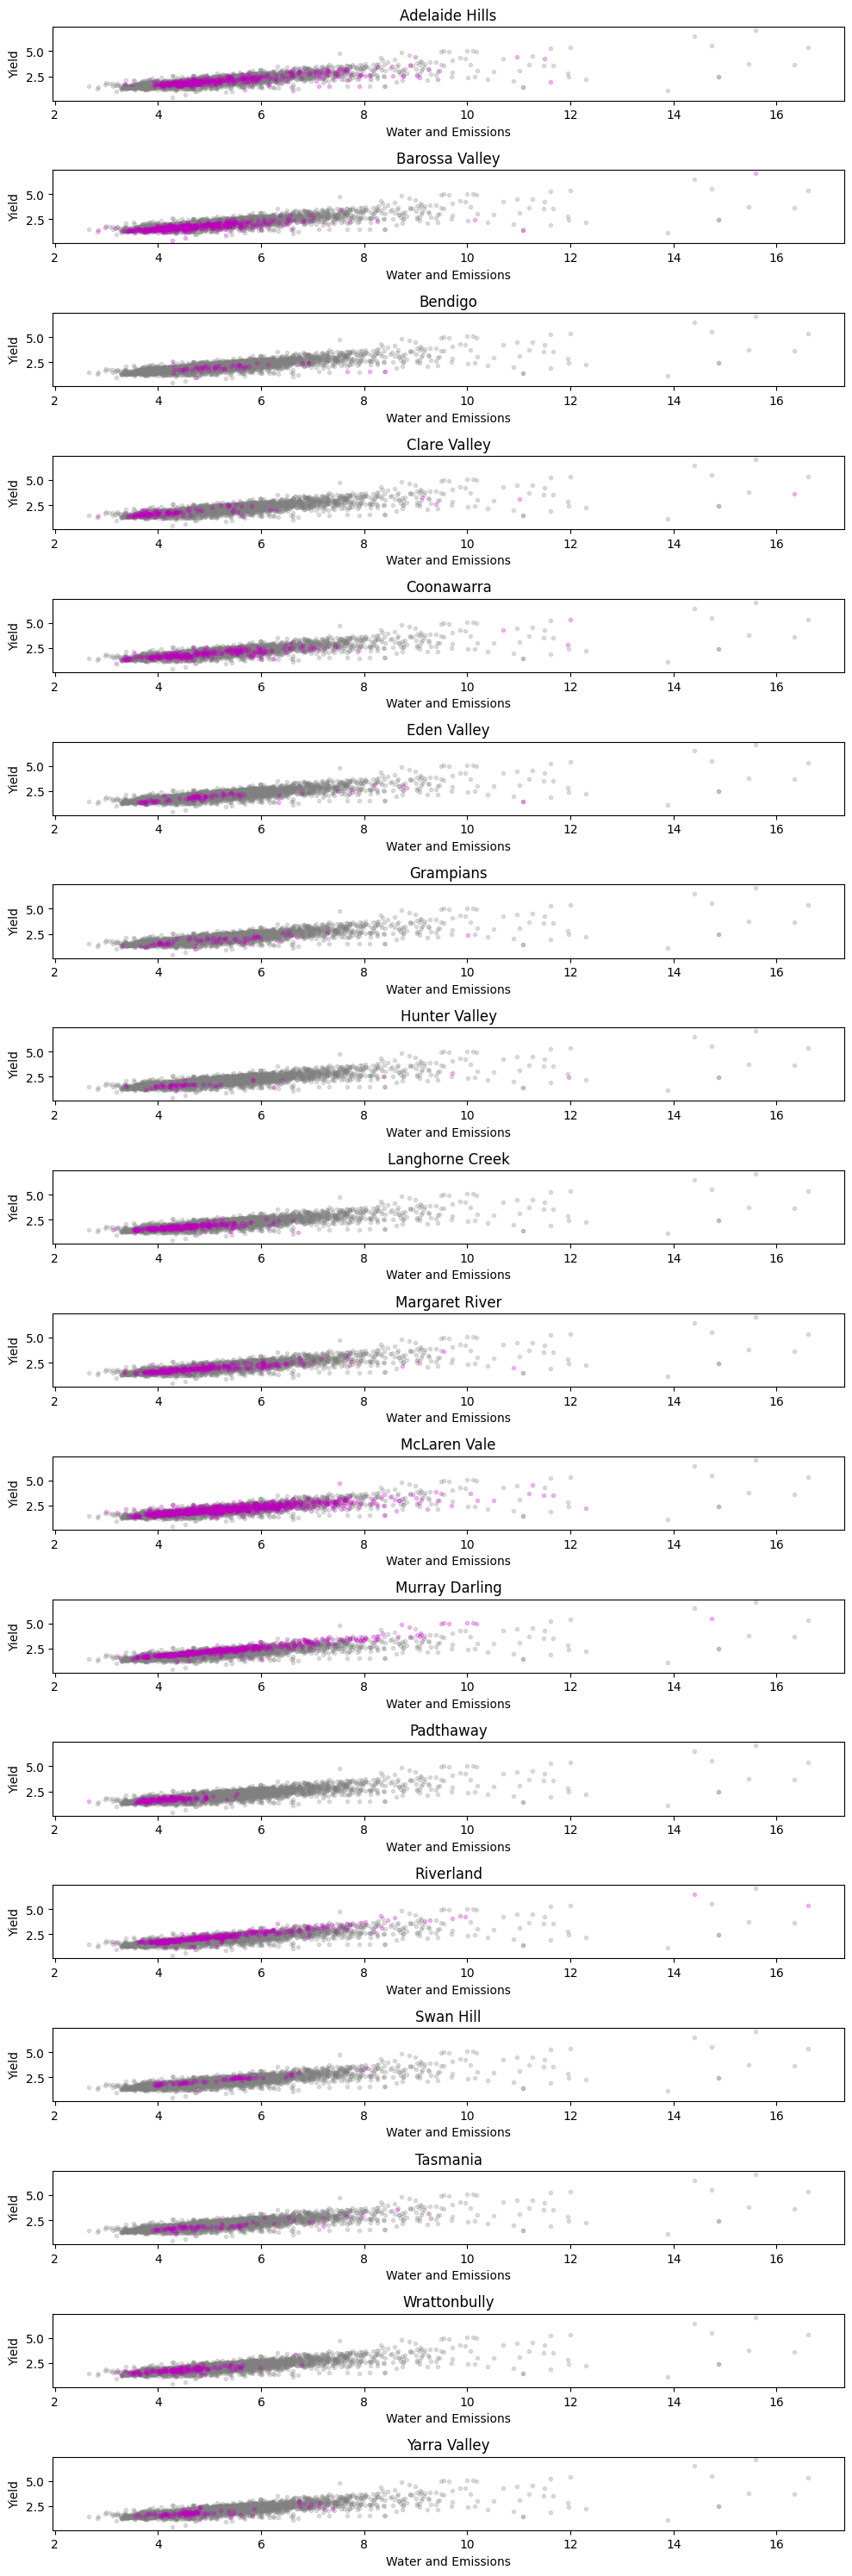

In [42]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Finances

In [43]:
df.groupby("giregion")["average_per_tonne"].describe()

count         mean          std     min      25%  \
giregion                                                                     
Adelaide Hills             60.0  1878.683333   380.167960  1025.0  1703.75   
Adelaide Plains             5.0  1227.000000   191.428838   935.0  1200.00   
Alpine Valleys              2.0  1125.000000   247.487373   950.0  1037.50   
Barossa Valley             95.0  2836.252632  1363.352103   757.0  2050.00   
Barossa Zone                3.0  2043.333333   487.476495  1530.0  1815.00   
Beechworth                  1.0  2600.000000          NaN  2600.0  2600.00   
Bendigo                    13.0  1503.230769   417.431462   750.0  1400.00   
Big Rivers Zone Other       0.0          NaN          NaN     NaN      NaN   
Blackwood Valley            2.0  1125.000000   318.198052   900.0  1012.50   
Canberra District           5.0  2176.000000   599.691587  1500.0  1800.00   
Clare Valley               22.0  1941.909091   701.918386  1129.0  1461.25   
Coonawarra                 38.0  2124.826316   818.951363  1100.0  1593.25   
Cowra                       0.0          NaN          NaN     NaN      NaN   
Currency Creek              4.0  1554.500000   472.737771  1018.0  1229.50   
Eden Valley                27.0  2084.074074   445.862425  1214.0  1779.50   
Geelong                     0.0          NaN          NaN     NaN      NaN   
Geographe                   0.0          NaN          NaN     NaN      NaN   
Glenrowan                   0.0          NaN          NaN     NaN      NaN   
Goulburn Valley             1.0  1113.000000          NaN  1113.0  1113.00   
Grampians                   5.0  1830.000000   449.444101  1300.0  1450.00   
Great Southern              3.0  2067.166667  1033.251704  1350.0  1475.00   
Gundagai                    1.0   850.000000          NaN   850.0   850.00   
Heathcote                   2.0  1100.000000    70.710678  1050.0  1075.00   
Henty                       0.0          NaN          NaN     NaN      NaN   
Hunter Valley               2.0  1862.500000   265.165043  1675.0  1768.75   
Kangaroo Island             1.0  1300.000000          NaN  1300.0  1300.00   
King Valley                 8.0  1018.755000   113.667347   880.0   937.50   
Langhorne Creek            45.0  1062.502667   370.529436   525.0   832.00   
Macedon Ranges              1.0  3494.000000          NaN  3494.0  3494.00   
Margaret River             46.0  1773.099565   556.838382  1100.0  1381.25   
McLaren Vale              214.0  2368.861121  1753.029360   545.0  1800.00   
Mornington Peninsula        3.0  2833.333333   404.145188  2600.0  2600.00   
Mount Benson                1.0  1600.000000          NaN  1600.0  1600.00   
Mount Gambier               1.0  1600.000000          NaN  1600.0  1600.00   
Mudgee                      6.0  1850.000000   126.491106  1700.0  1762.50   
Murray Darling             62.0   489.309032   174.324358   160.0   398.50   
Orange                     18.0  1637.666667   620.962062   260.0  1269.75   
Other                       3.0  1186.666667  1137.555859   510.0   530.00   
Padthaway                  20.0  1581.235000   712.711361   830.0  1093.75   
Pemberton                   5.0  1429.400000   250.523053  1200.0  1200.00   
Pyrenees                    0.0          NaN          NaN     NaN      NaN   
Riverina                    0.0          NaN          NaN     NaN      NaN   
Riverland                  82.0   536.944268   192.420887   253.0   430.75   
Robe                        1.0  1200.000000          NaN  1200.0  1200.00   
Rutherglen                  9.0  1315.333333   568.540236   700.0  1015.00   
Southern Fleurieu           4.0  1088.000000   130.802650   952.0   988.00   
Southern Flinders Ranges    1.0   838.000000          NaN   838.0   838.00   
Southern Highlands          0.0          NaN          NaN     NaN      NaN   
Strathbogie Ranges          2.0  1400.000000   141.421356  1300.0  1350.00   
Sunbury                     0.0          NaN    

In [44]:
rpy2.ipython.html.init_printing()
r = robjects.r
#feature_list.append("average_per_tonne")

from data import mean_sale_price

avg_prices = df[
    df["average_per_tonne"].isnull()].apply(
    lambda x: mean_sale_price(x["giregion"],
                              x["data_year_id"]),
    axis=1)
df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"]!=0].index, feature_list].copy()
dfr["average_per_tonne"] = df.loc[df[df["average_per_tonne"]!=0].index, "average_per_tonne"]

dfr.to_csv("data.csv")

r.source("linear_model.r")

model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    2906
log(df$total_emissions + 1)                             1  3091.04      2905
log(df$water_used + 1)                                  1   213.13      2904
log(df$total_emissions + 1):log(df$area_harvested + 1)  1   522.69      2903
log(df$area_harvested + 1):log(df$water_used + 1)       1   610.22      2902
                                                       Resid. Dev
NULL                                                       5596.8
log(df$total_emissions + 1)                                2505.7
log(df$water_used + 1)                                     2292.6
log(df$total_emissions + 1):log(df$

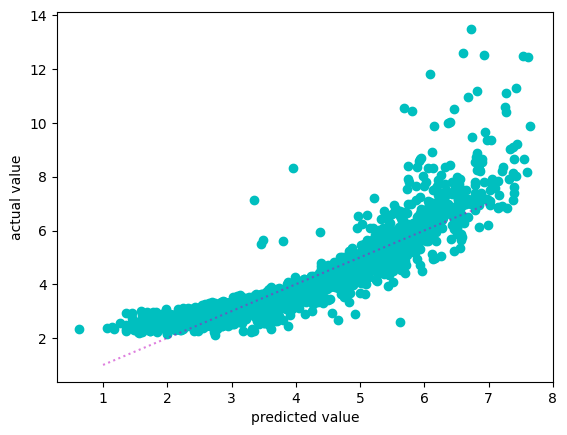

In [45]:
fig, ax = plt.subplots()

plt.plot([1,7], [1,7], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

In [51]:
rpy2.ipython.html.init_printing()
r = robjects.r

dfr = df[df["total_vineyard_fuel"]>0].copy()

dfr.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "(log(df$average_per_tonne*(1+df$tonnes_grapes_harvested)))"
    "~ df$total_emissions"
    "+ log(df$water_used+1)"
    "+ log(df$area_harvested+1)"
    "+ log(1+df$fertiliser)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * (1 + df$tonnes_grapes_harvested)))

Terms added sequentially (first to last)


                           Df Deviance Resid. Df Resid. Dev
NULL                                         506    1147.01
df$total_emissions          1  303.148       505     843.87
log(df$water_used + 1)      1  310.788       504     533.08
log(df$area_harvested + 1)  1  299.171       503     233.91
log(1 + df$fertiliser)      1    9.904       502     224.00

***************
* GLM Summary *


Call:
glm(formula = eval(parse(text = formula)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0093  -0.2468   0.0863   0.3872   1.9671  

Coefficients:
                                    Estimate        Std. Error t value
(Intercept)                 8.71375431850961  0.11425933504586  76.263
df$total_emissions          0.00000000006515  0.00000000030006   0.217
lo

In [104]:
rpy2.ipython.html.init_printing()
r = robjects.r

dfr = df[df["total_vineyard_fuel"]>0].copy()

dfr.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(1+(df$average_per_tonne*(df$tonnes_grapes_harvested)))/log(df$area_harvested+1)"
    "~ "
    "+ log(1+df$fertiliser)"
    "+ log(1+df$total_emissions)"
    "+ log(1+df$water_used)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(1 + (df$average_per_tonne * (df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                            Df Deviance Resid. Df Resid. Dev
NULL                                          506    1247.27
log(1 + df$fertiliser)       1   127.00       505    1120.27
log(1 + df$total_emissions)  1   598.87       504     521.40
log(1 + df$water_used)       1    29.07       503     492.33

***************
* GLM Summary *


Call:
glm(formula = eval(parse(text = formula)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4201  -0.4475  -0.1146   0.3348   7.1395  

Coefficients:
                            Estimate Std. Error t value    Pr(>|t|)    
(Intercept)                 14.25378    0.51037  27.928     < 2e-16 ***
log(1 + df$fertiliser)      -0.03409    0.01587  -2.148      0.0322 *  
log(1 + df$total_emissions)

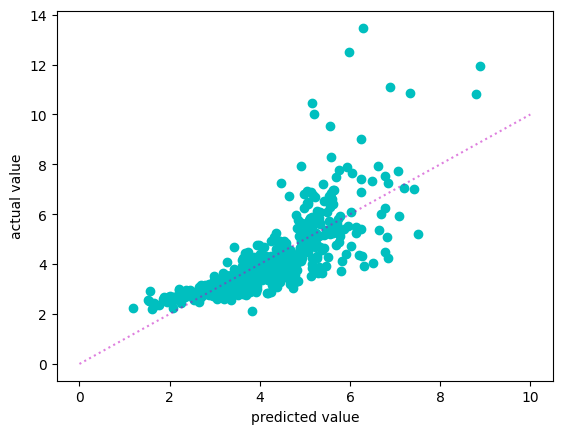

In [103]:
fig, ax = plt.subplots()

plt.plot([0,10], [0,10], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

(array([  8.,  11.,  26.,  63., 176., 112.,  65.,  20.,   8.,   6.,   3.,
          2.,   2.,   1.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([-2.42013343, -1.94215136, -1.46416929, -0.98618722, -0.50820515,
        -0.03022308,  0.44775899,  0.92574106,  1.40372313,  1.8817052 ,
         2.35968727,  2.83766934,  3.31565141,  3.79363348,  4.27161555,
         4.74959762,  5.22757969,  5.70556176,  6.18354383,  6.6615259 ,
         7.13950797]),
 <BarContainer object of 20 artists>)

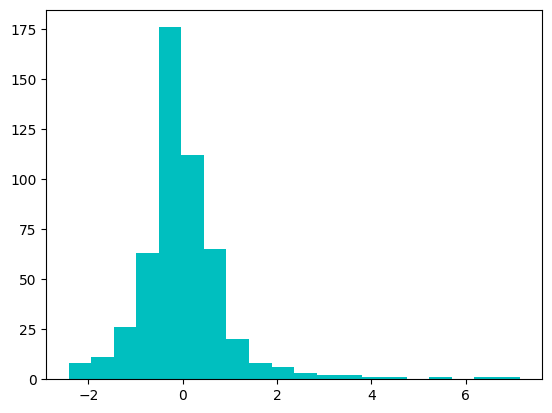

In [105]:
plt.hist(model[1], bins=20, color="c")

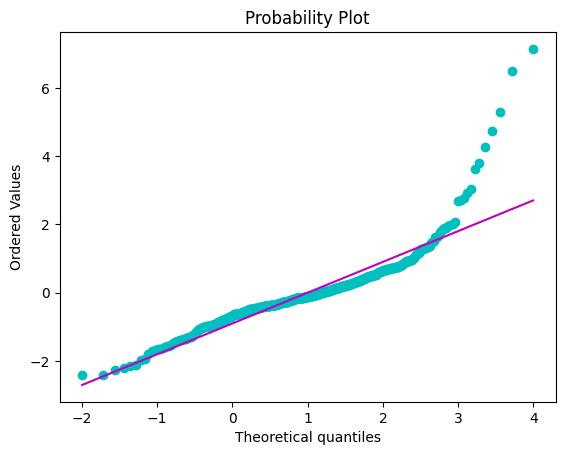

In [106]:
from scipy import stats


from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    model[1]
    , dist='norm'
    , sparams=(1)
    , plot=ax
)

ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

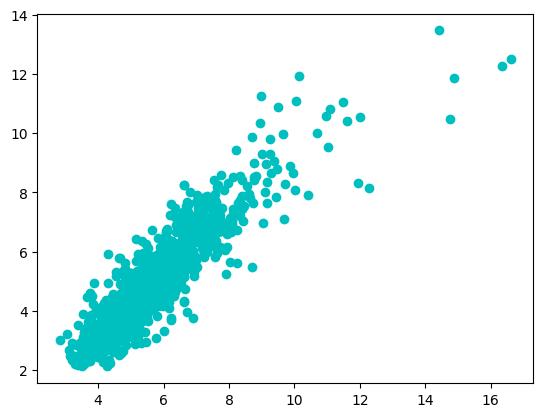

In [109]:
dfr["yield_avg"] = (1+(dfr['average_per_tonne']*dfr['tonnes_grapes_harvested'])).apply(np.log).div((1+dfr["area_harvested"]).apply(np.log))

plt.scatter(dfr["water_and_emmissions"], dfr["yield_avg"], color="c")

plt.show()

In [110]:
df["yield_avg"] = (1+(df['average_per_tonne']*df['tonnes_grapes_harvested'])).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

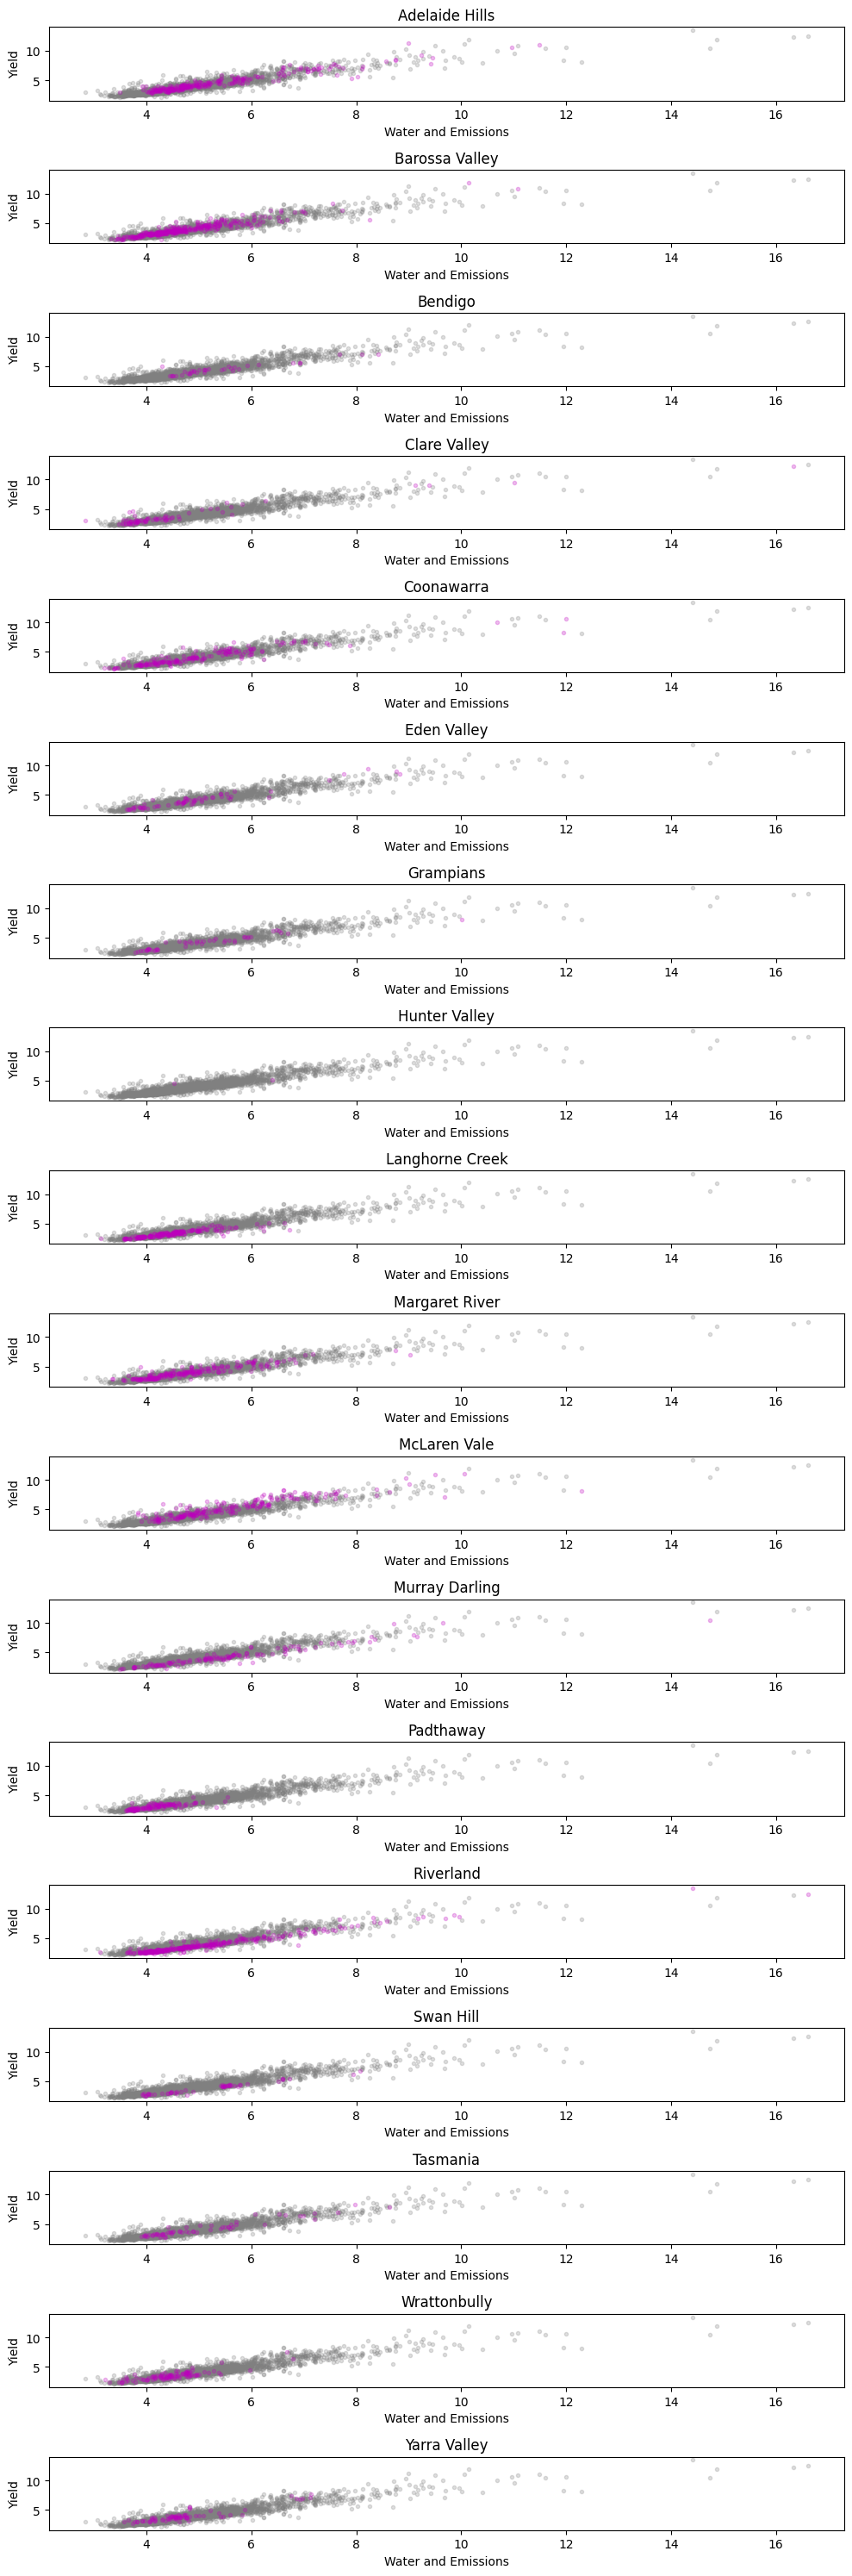

In [111]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

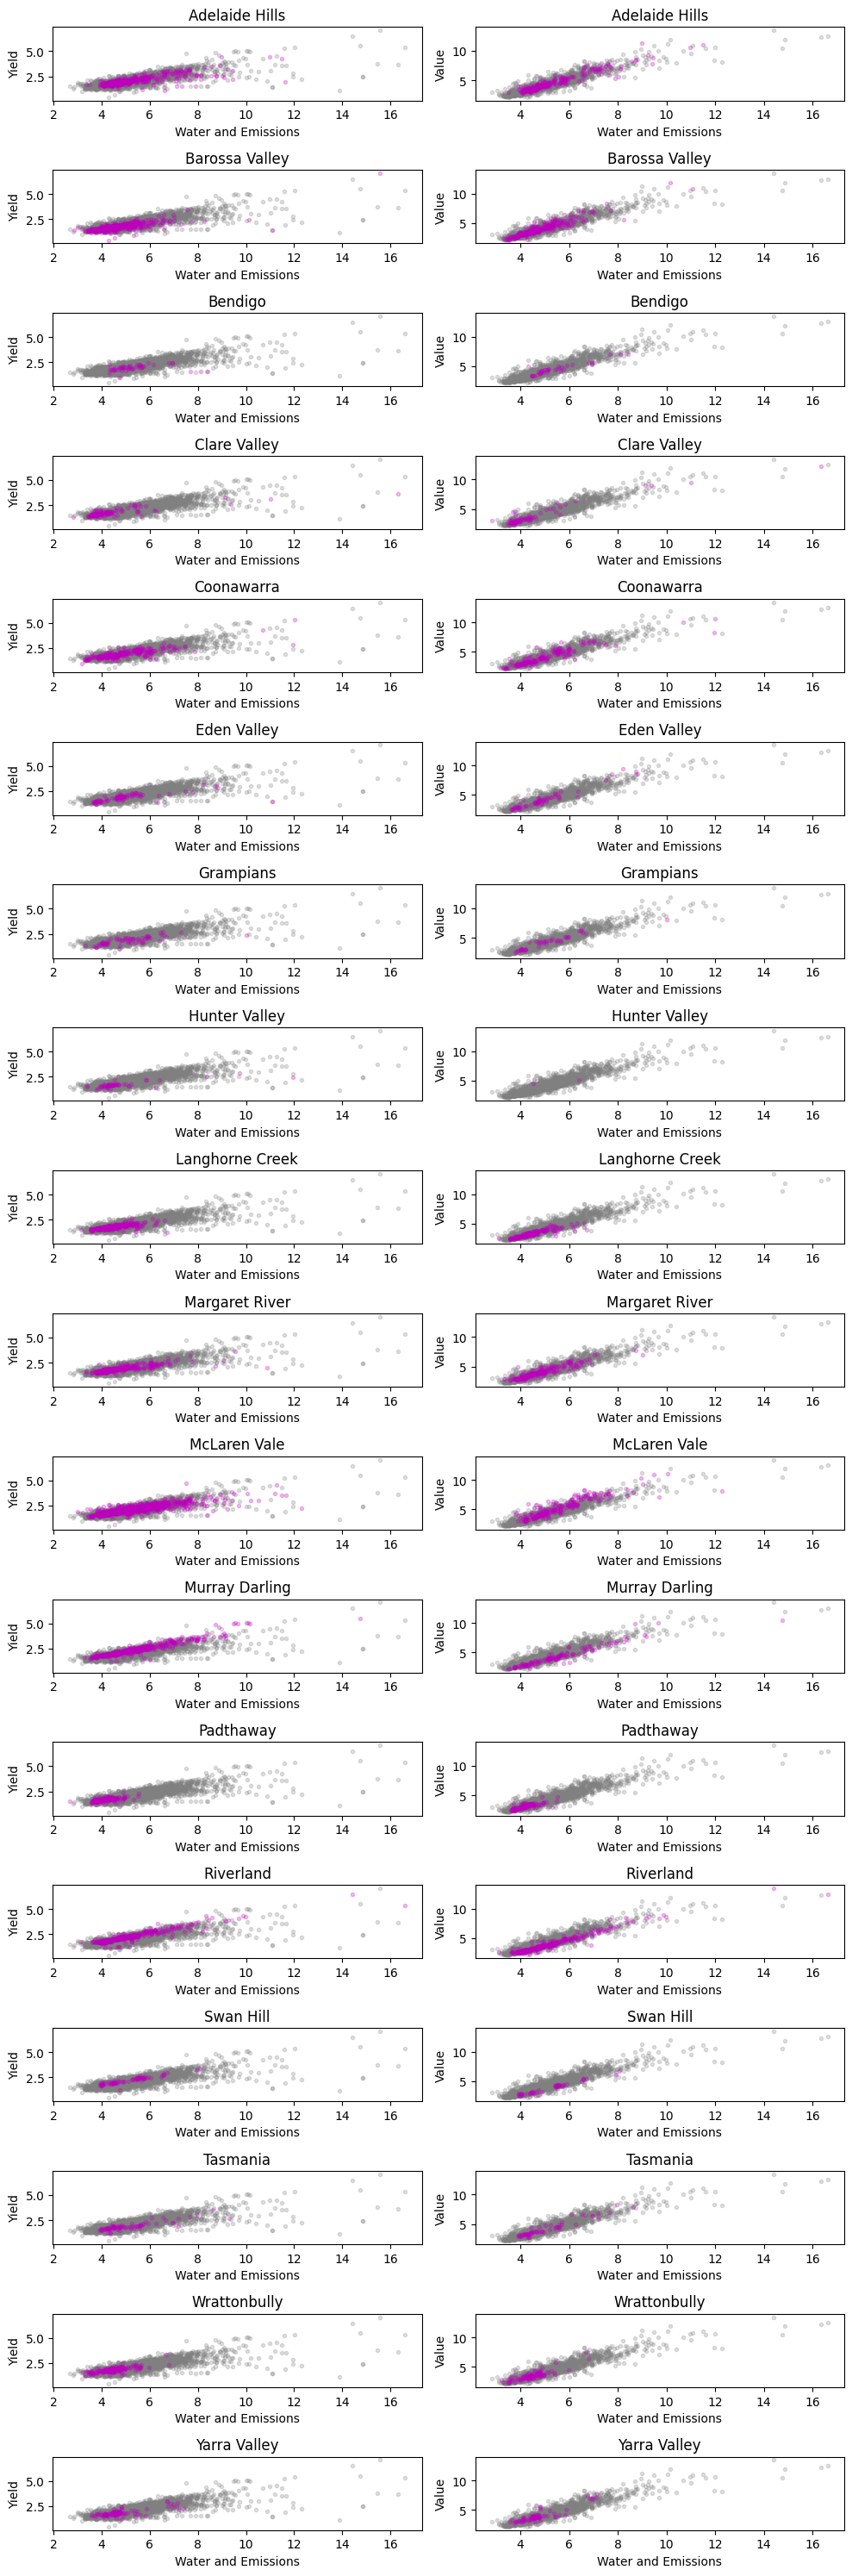

In [112]:
fig, ax = plt.subplots(len(region_selection), 2,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i][0].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][0].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][0].set_title(region)
    ax[i][0].set_xlabel("Water and Emissions")
    ax[i][0].set_ylabel('Yield')
    ##
    axscatter = ax[i][1].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][1].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][1].set_title(region)
    ax[i][1].set_xlabel("Water and Emissions")
    ax[i][1].set_ylabel('Value')
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Regional Climates

In [114]:
df["rain"] = df["giregion"].apply(rain)
df["temp"] = df["giregion"].apply(temp)
df.loc[df["rain"]=="Unknown Climate", "rain"] = np.nan
df.loc[df["temp"]=="Unknown Climate", "temp"] = np.nan
df["climate"] = df["temp"] + " " + df["rain"]
df.loc[df["climate"]=="Unknown Climate Unknown Climate", "climate"] = np.nan

In [115]:
palette=[
        "#009292",
        "#ff6db6",
        "#490092",
        "#b66dff",
        "#6db6ff",
        "#b6dbff",
        "#920000",
        "#db6d00",
        "#24ff24",
        "#ffff6d",
        "#006ddb",
        "#000000",
        "#004949",
        "#ffb6db",
        "#924900",
    ]

import matplotlib.cm as cm

climate_color = {}
color = iter(palette)

climate_selection = df["climate"].unique()

for i in range(len(climate_selection)):
   climate_color[climate_selection[i]] = i = next(color)

df['clim_colors'] = df.loc[df["climate"].notnull(), "climate"].apply(lambda x: climate_color[x])



In [116]:
df["climate"].unique()

array(['Warm Very Dry', 'Mild Dry', 'Hot Damp', 'Cool Dry', 'Warm Dry',
       'Hot Very Dry', 'Cool Damp', 'Mild Very Dry', 'Warm Damp', nan,
       'Mild Damp', 'Cool Very Dry'], dtype=object)

<AxesSubplot: >

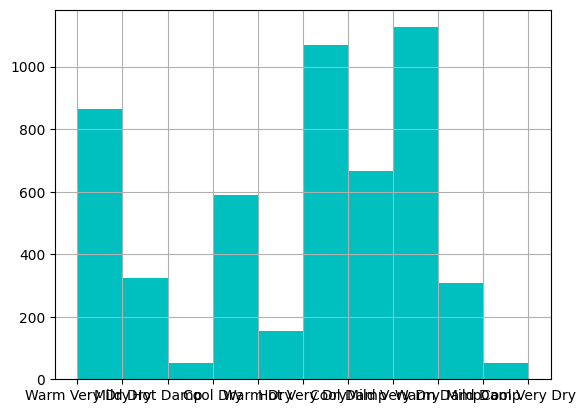

In [117]:
df["climate"].hist(color="c")

<AxesSubplot: >

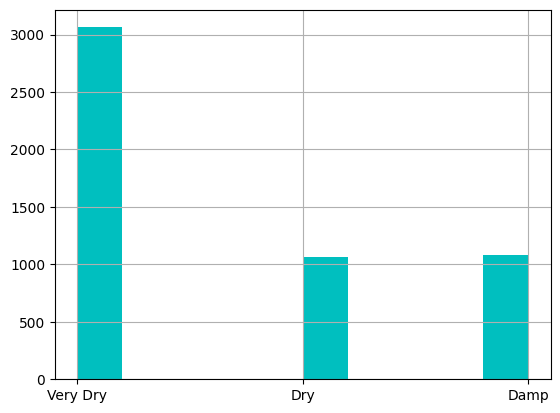

In [118]:
df["rain"].hist(color="c")

<AxesSubplot: >

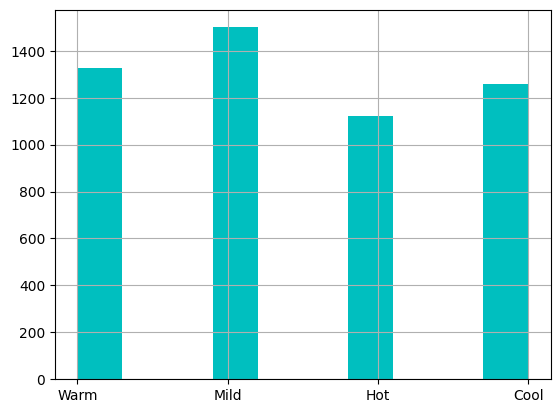

In [119]:
df["temp"].hist(color="c")

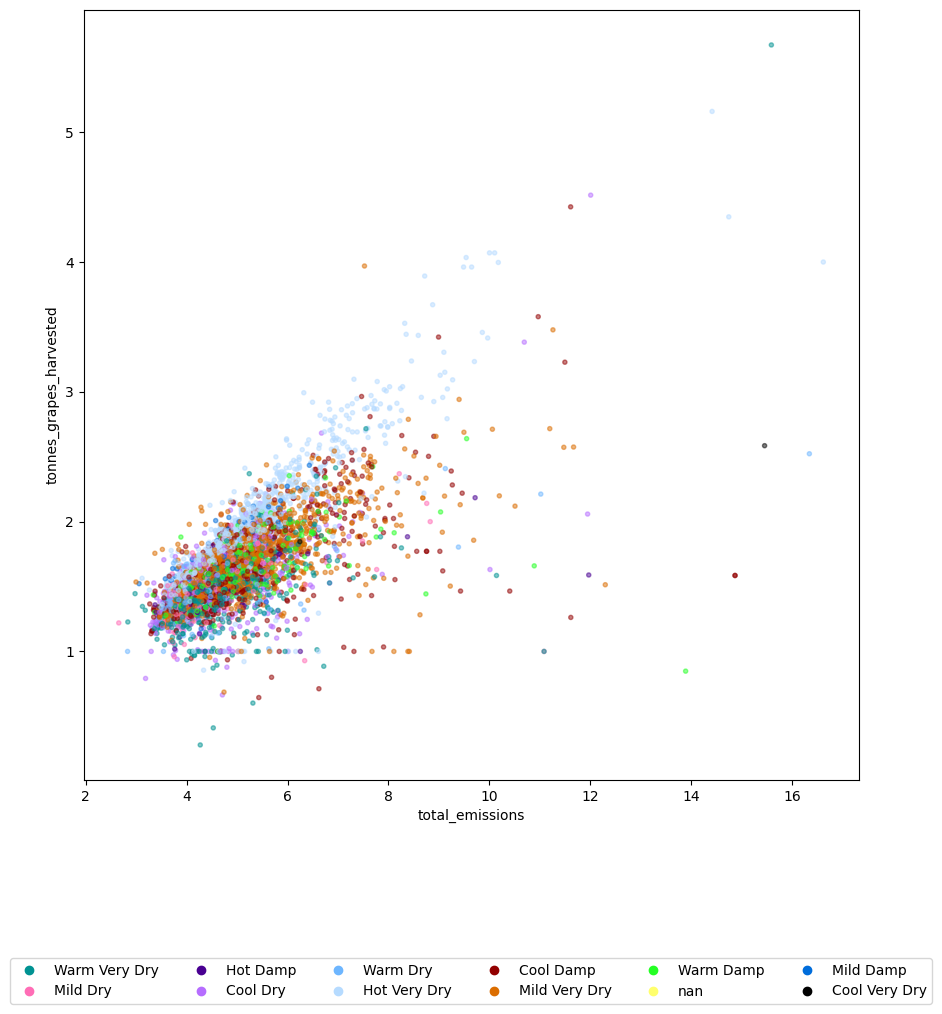

In [120]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

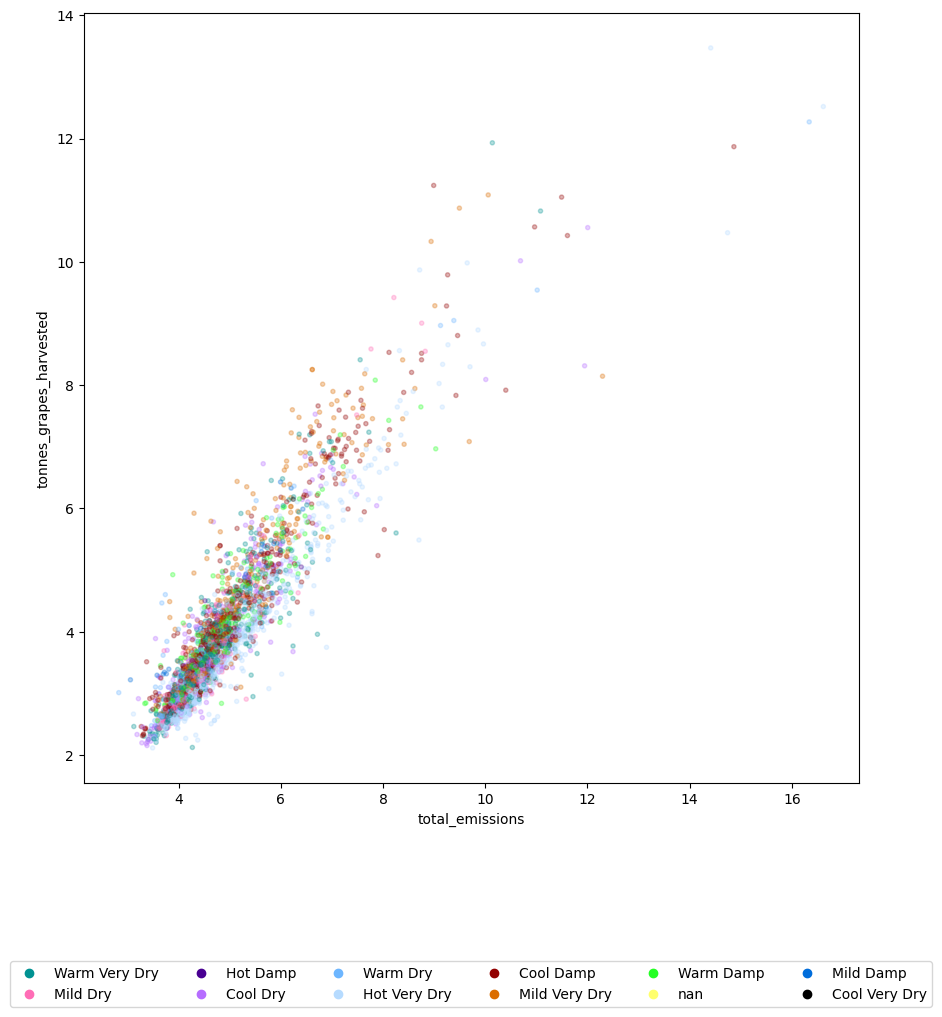

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield_avg'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.3
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

In [122]:
import matplotlib.cm as cm

rain_color = {}
color = iter(palette)

rain_selection = df.loc[df["climate"].notnull(), "rain"].unique()

for i in range(len(rain_selection)):
   rain_color[rain_selection[i]] = i = next(color)

df['rain_colors'] = df.loc[df["climate"].notnull(),"rain"].apply(lambda x: rain_color[x])

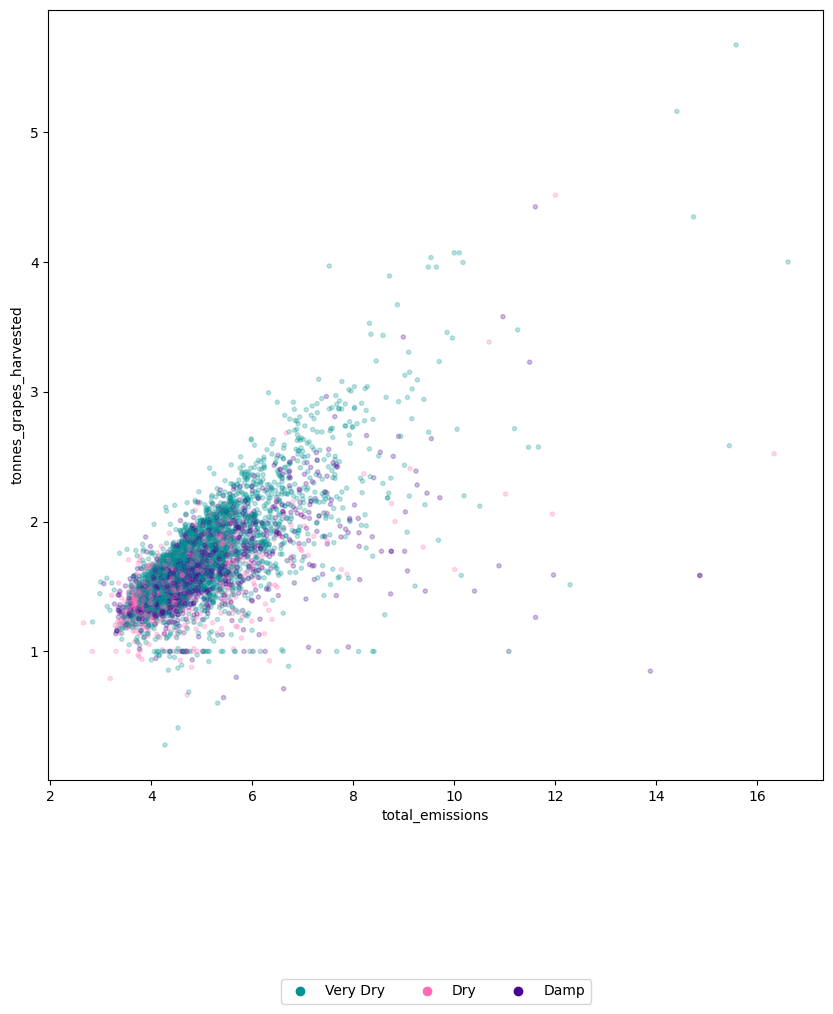

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

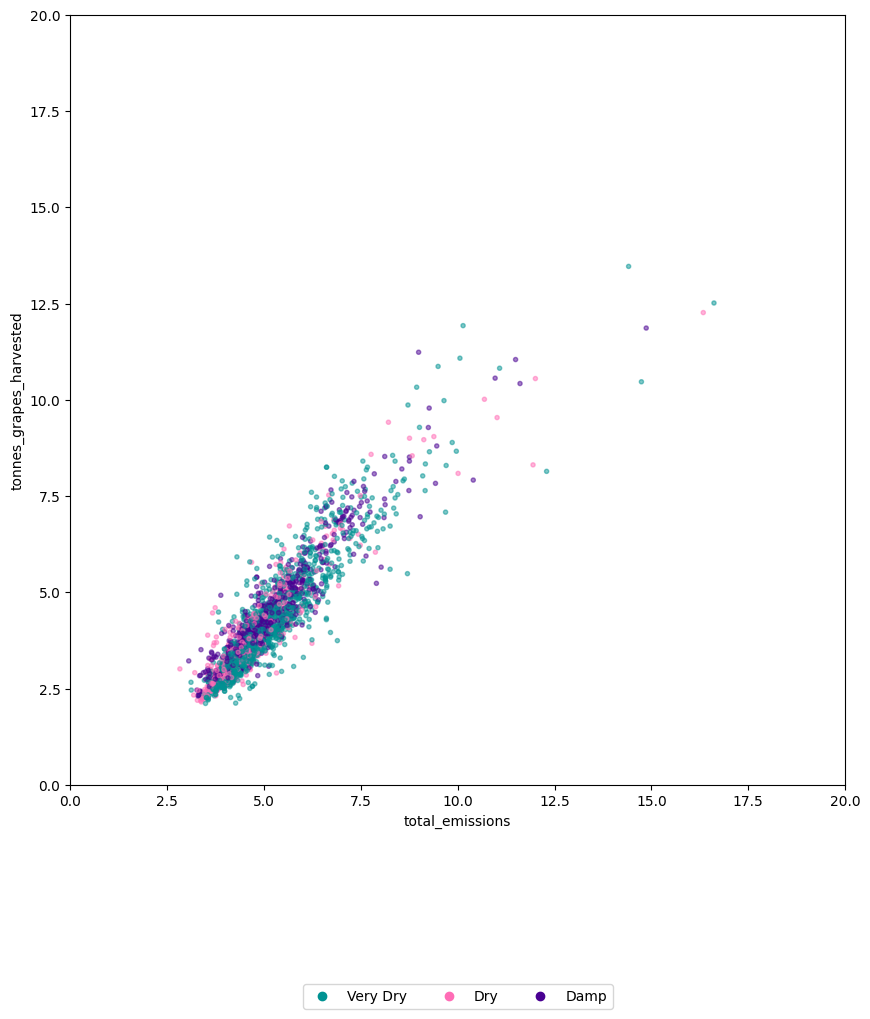

In [124]:
fig, ax = plt.subplots(figsize=(10, 10))
rain_map = {'Very Dry': "brown", 'Damp': "blue", 'Dry': "brown", 'Unknown Climate': None}

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')
ax.set_xlim([0,20])
ax.set_ylim([0,20])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [125]:
temp_selection = df.groupby("temp").count()[(df.groupby("temp").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

temp_color = {}
color = iter(palette)
temp_selection = df.loc[df["climate"].notnull(), "temp"].unique()

for i in range(len(temp_selection)):
   temp_color[temp_selection[i]] = i = next(color)

df['temp_colors'] = df.loc[df["climate"].notnull(), "temp"].apply(lambda x: temp_color[x])

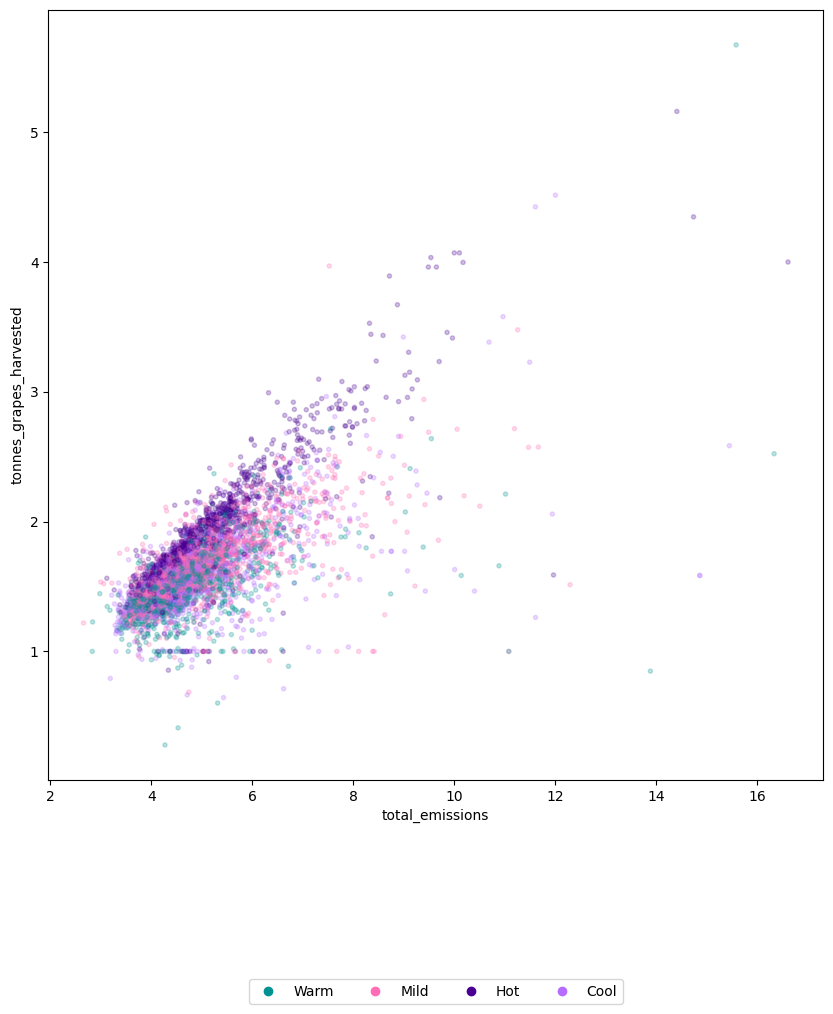

In [126]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

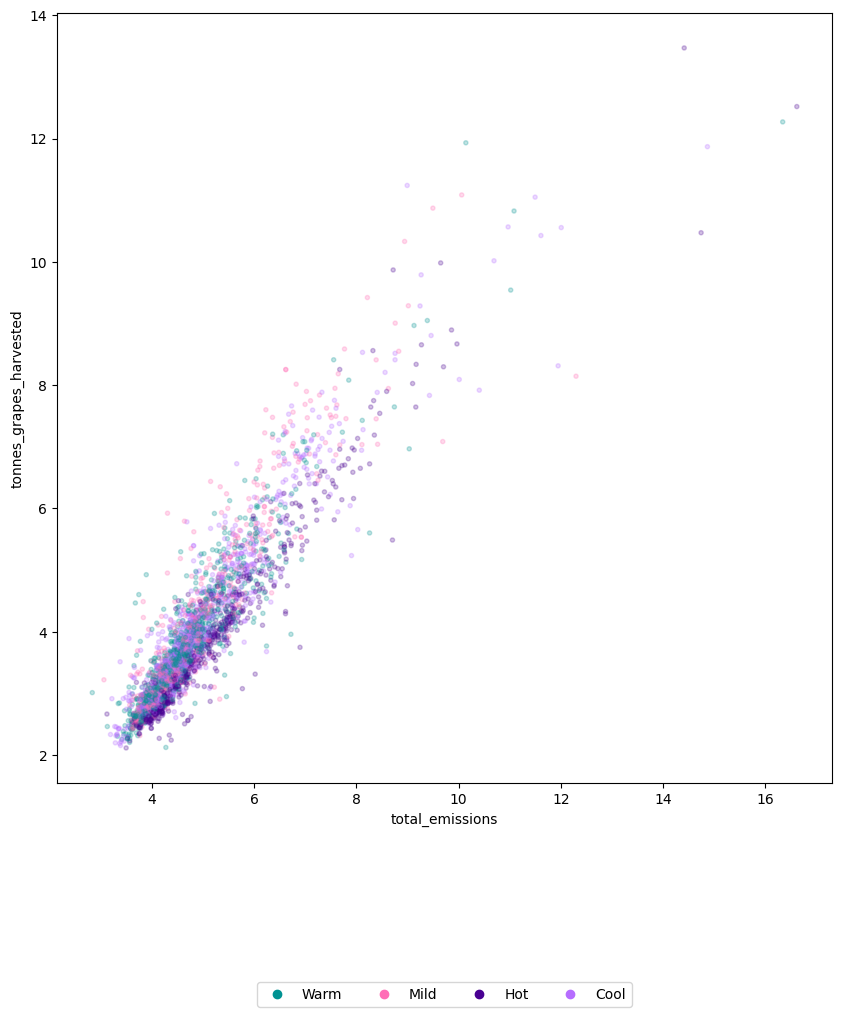

In [127]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [154]:
type(climate) is str

True

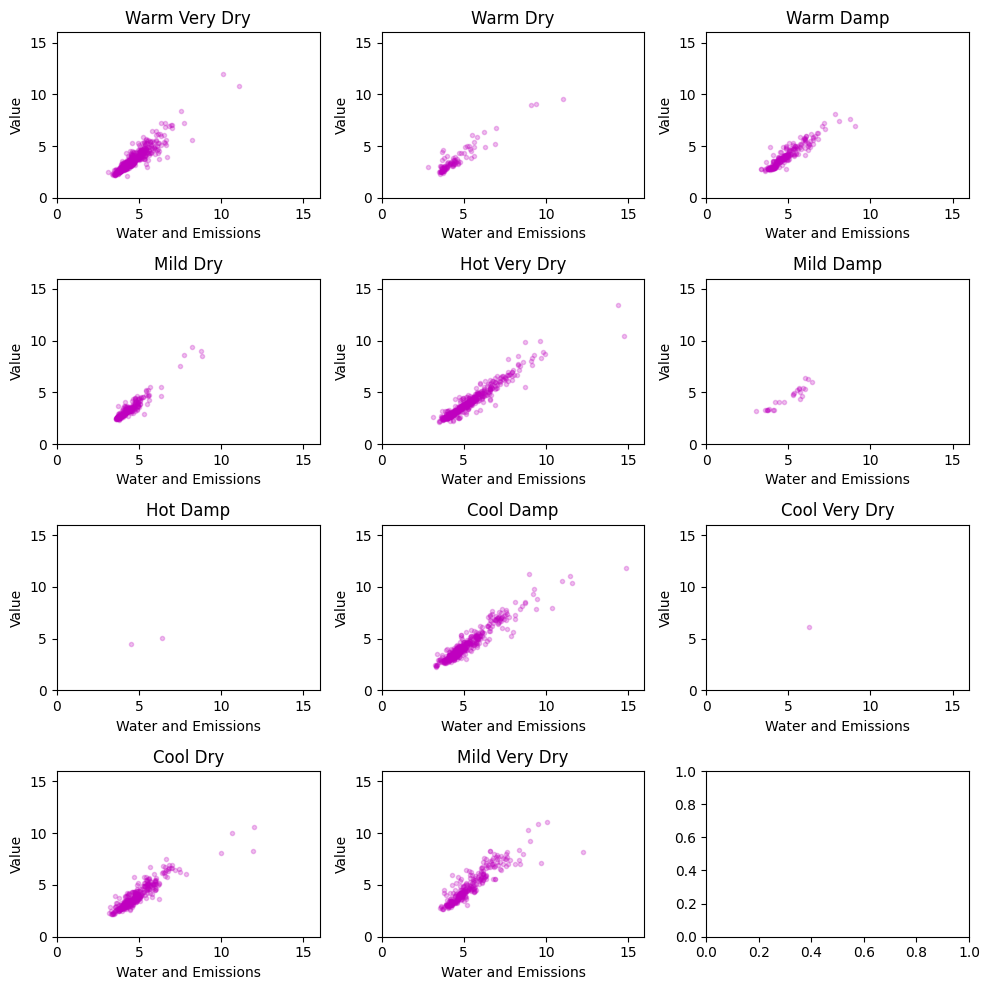

In [158]:
fig, ax = plt.subplots(4, 3,  figsize=(10, 10))

i=0
j=0

for climate in df["climate"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["climate"]==climate, "water_and_emmissions"]
        , df.loc[df["climate"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,16])
    ax[i][j].set_ylim([0,16])
    i += 1
    if i>3:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

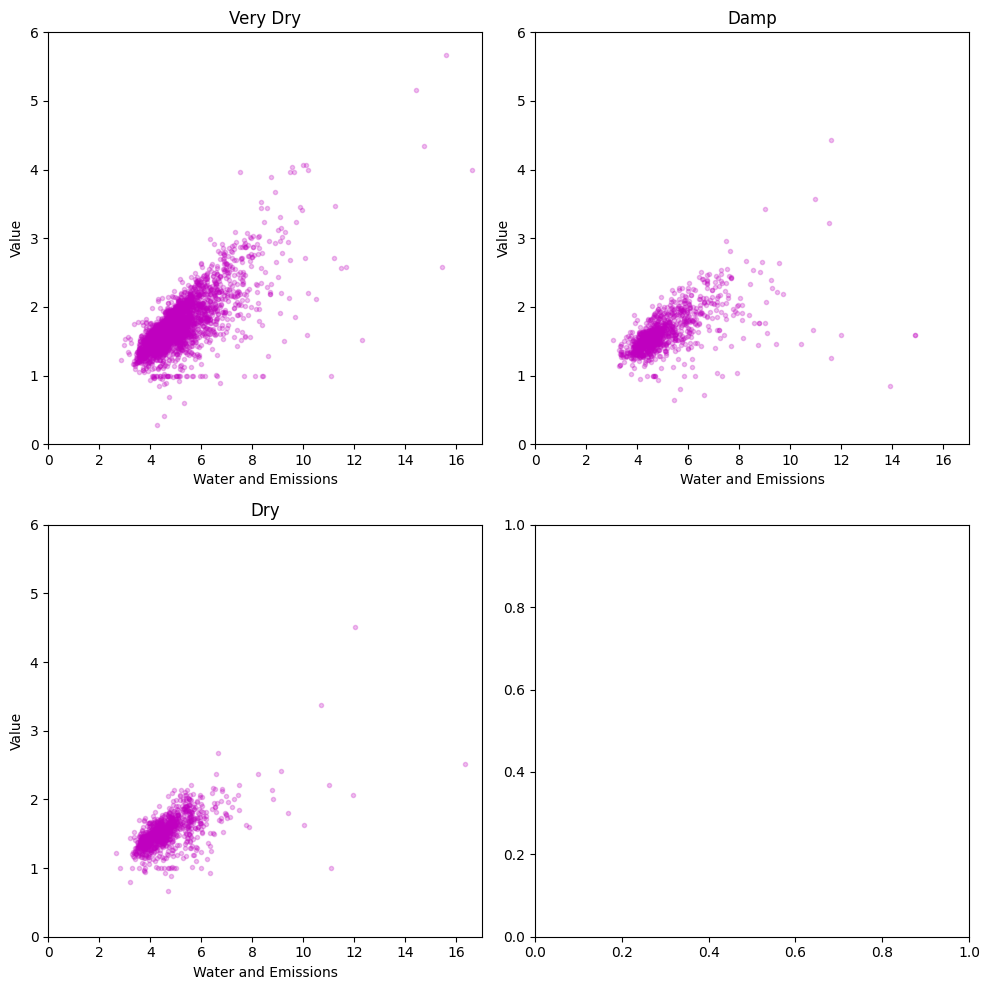

In [199]:
fig, ax = plt.subplots(2, 2,  figsize=(10, 10))

i=0
j=0

for climate in df["rain"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["rain"]==climate, "water_and_emmissions"]
        , df.loc[df["rain"]==climate,"yield"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,17])
    ax[i][j].set_ylim([0,6])
    i += 1
    if i>1:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

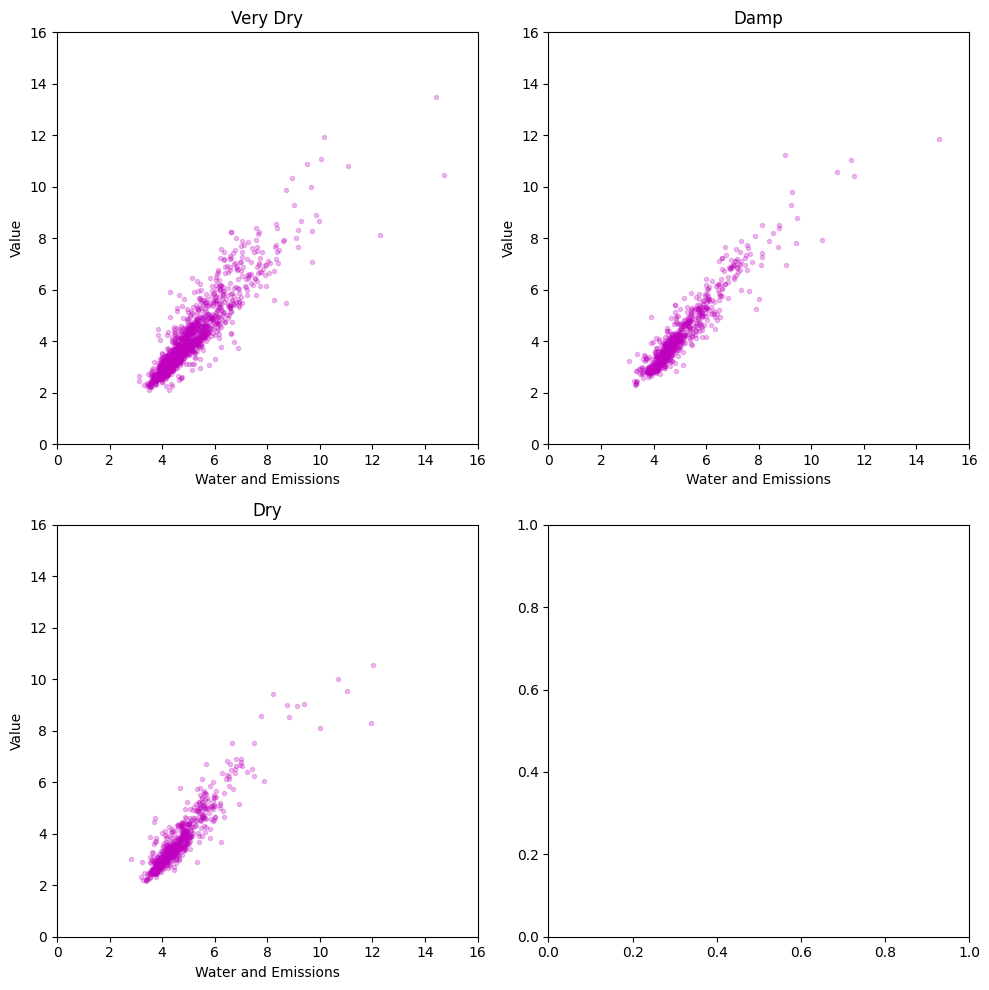

In [161]:
fig, ax = plt.subplots(2, 2,  figsize=(10, 10))

i=0
j=0

for climate in df["rain"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["rain"]==climate, "water_and_emmissions"]
        , df.loc[df["rain"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,16])
    ax[i][j].set_ylim([0,16])
    i += 1
    if i>1:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

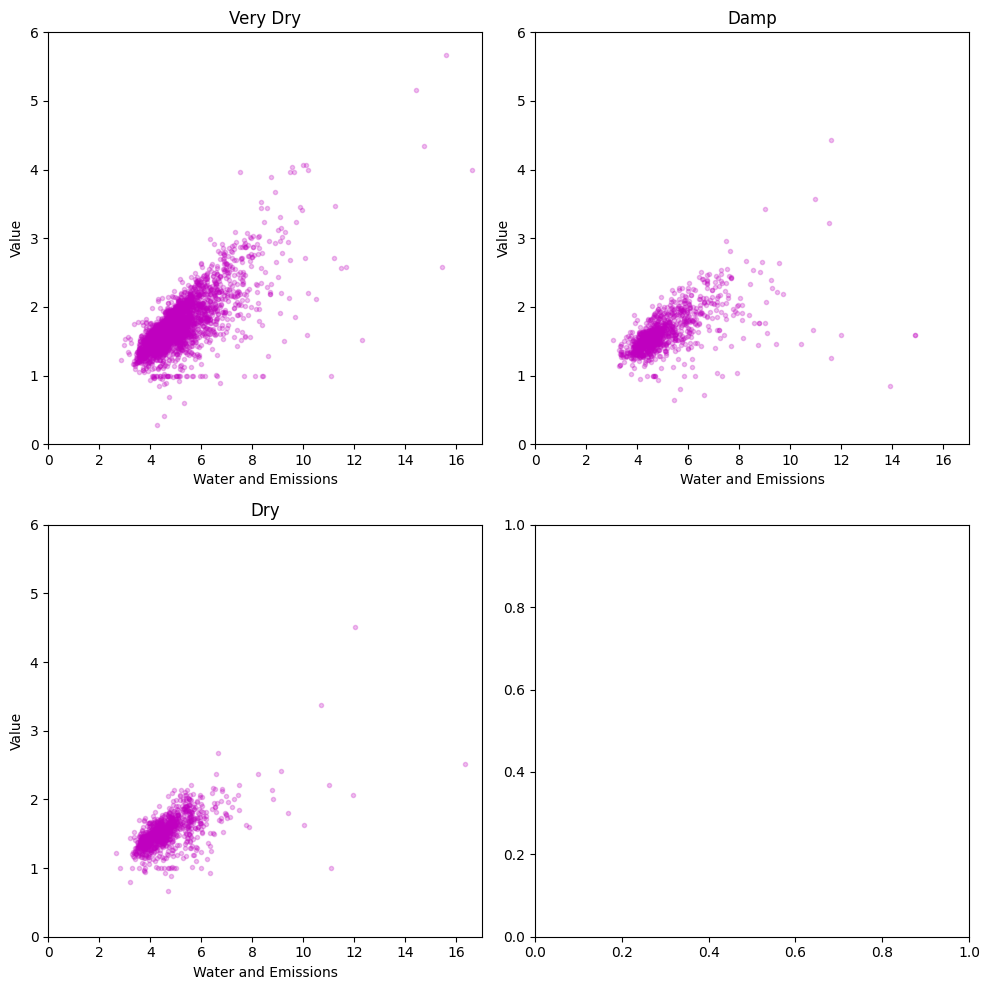

In [203]:
fig, ax = plt.subplots(2, 2,  figsize=(10, 10))

i=0
j=0

for climate in df["rain"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["rain"]==climate, "water_and_emmissions"]
        , df.loc[df["rain"]==climate,"yield"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,17])
    ax[i][j].set_ylim([0,6])
    i += 1
    if i>1:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

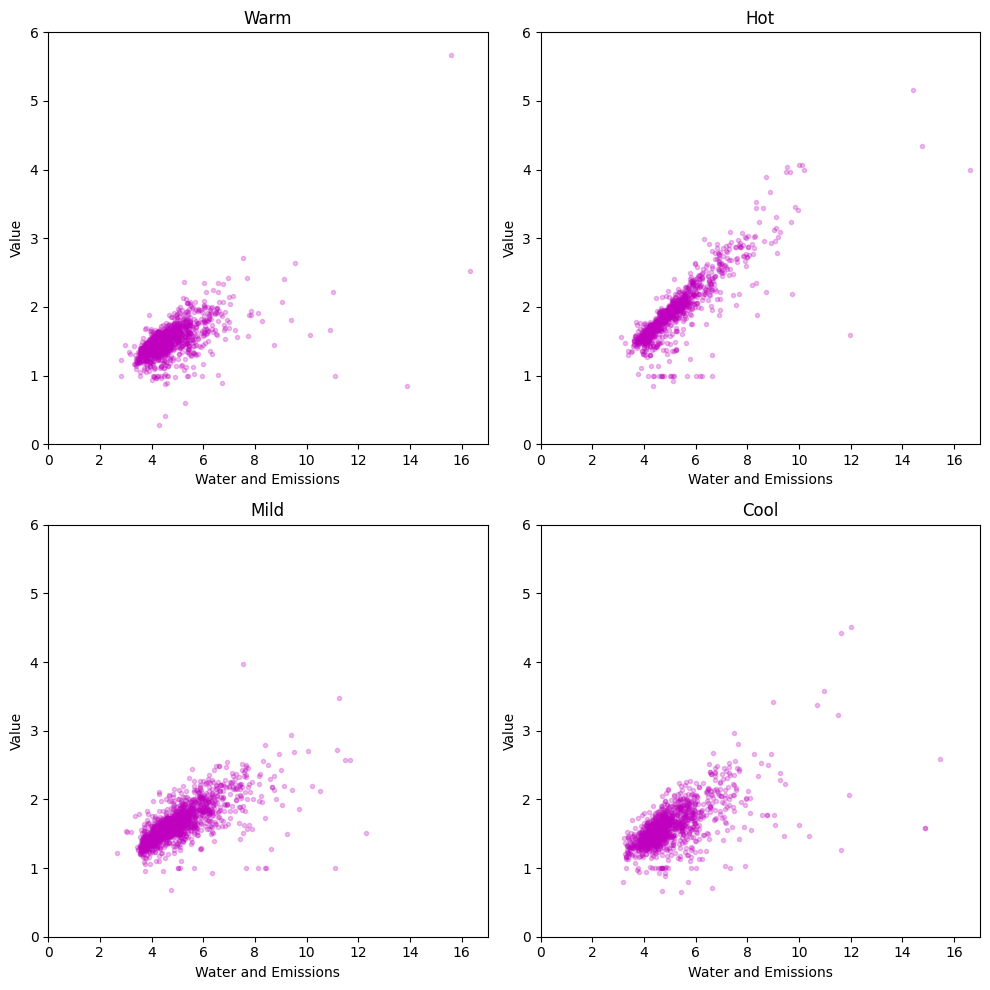

In [207]:
fig, ax = plt.subplots(2, 2,  figsize=(10, 10))

i=0
j=0

for climate in df["temp"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["temp"]==climate, "water_and_emmissions"]
        , df.loc[df["temp"]==climate,"yield"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,17])
    ax[i][j].set_ylim([0,6])
    i += 1
    if i>1:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

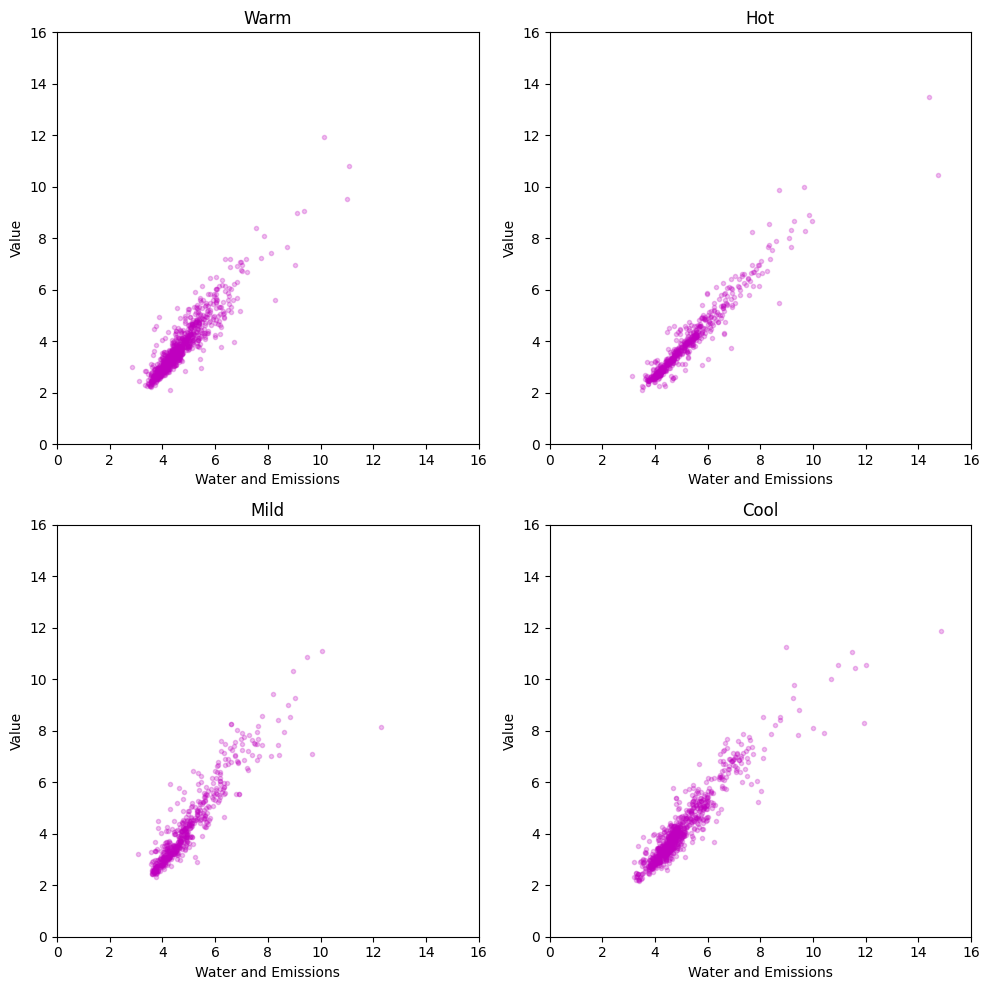

In [206]:
fig, ax = plt.subplots(2, 2,  figsize=(10, 10))

i=0
j=0

for climate in df["temp"].unique():
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["temp"]==climate, "water_and_emmissions"]
        , df.loc[df["temp"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,16])
    ax[i][j].set_ylim([0,16])
    i += 1
    if i>1:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

In [232]:
len(region_selection)

18

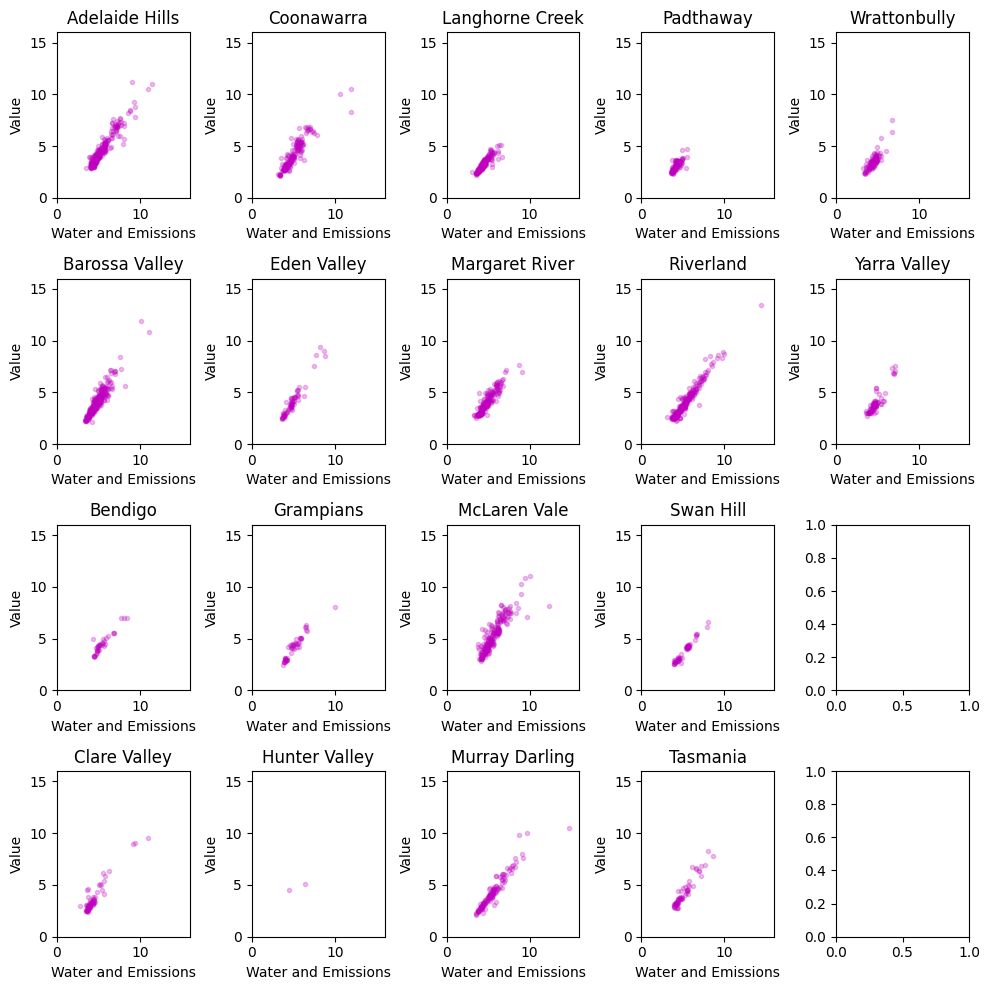

In [236]:
fig, ax = plt.subplots(4, 5,  figsize=(10, 10))

i=0
j=0

for climate in region_selection:
    if type(climate) is not str:
        continue
    scatter = ax[i][j].scatter(
        df.loc[df["giregion"]==climate, "water_and_emmissions"]
        , df.loc[df["giregion"]==climate,"yield_avg"]
        , color="m"
        , alpha=0.25
        , label=climate
        , marker= "."
    )
    ax[i][j].set_title(climate)
    ax[i][j].set_xlabel("Water and Emissions")
    ax[i][j].set_ylabel('Value')

    ax[i][j].set_xlim([0,16])
    ax[i][j].set_ylim([0,16])
    i += 1
    if i>3:
        j+=1
        i=0


#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

In [ ]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))

df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

In [222]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[(df["temp"]=="Warm")].to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(1+df$tonnes_grapes_harvested)/(log(1+df$area_harvested))"
    "~ log(1+df$water_used)/(log(1+df$area_harvested)) +"
    "log(1+df$total_emissions)/(log(1+df$area_harvested))"
)



***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(1 + df$tonnes_grapes_harvested)/(log(1 + df$area_harvested))

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    1327
log(1 + df$water_used)                                  1   6.1667      1326
log(1 + df$total_emissions)                             1   8.7530      1325
log(1 + df$water_used):log(1 + df$area_harvested)       1   2.7808      1324
log(1 + df$area_harvested):log(1 + df$total_emissions)  1   8.1343      1323
                                                       Resid. Dev
NULL                                                       86.301
log(1 + df$water_used)                                     80.134
log(1 + df$total_emissions)                                71.381
log(1 + df$water_used):log(1 + df$area_harvested)          6

In [ ]:
log(1+df$tonnes_grapes_harvested)/(log(1+df$area_harvested)) ~ log(1+df$water_used)/(log(1+df$area_harvested)) + log(1+df$total_emissions)/(log(1+df$area_harvested))

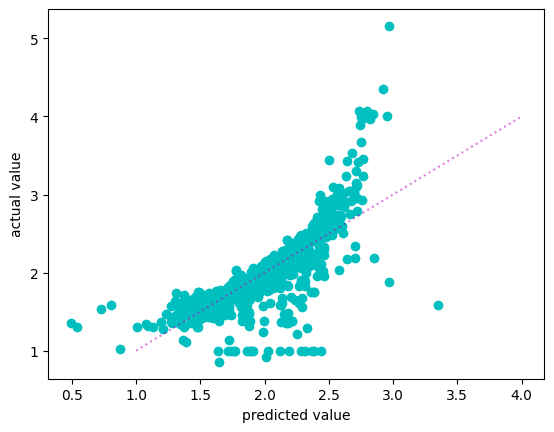

In [216]:
fig, ax = plt.subplots()

plt.plot([1,4], [1,4], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show() 

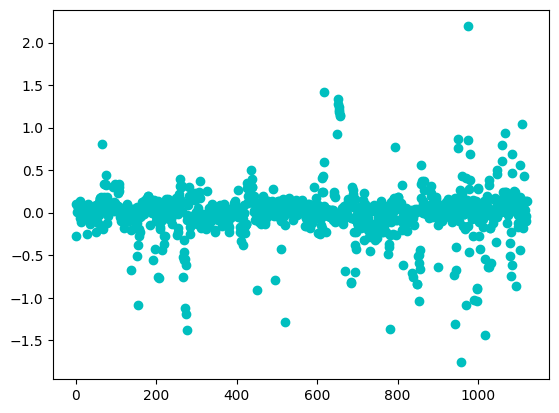

In [217]:
residuals = model[1]
plt.scatter(range(len(residuals)), residuals, color="c")

(array([  1.,   3.,   3.,   6.,   9.,  20.,  24.,  59., 442., 459.,  64.,
         12.,   5.,   5.,   4.,   4.,   1.,   0.,   0.,   1.]),
 array([-1.76169853, -1.56417358, -1.36664864, -1.16912369, -0.97159875,
        -0.7740738 , -0.57654885, -0.37902391, -0.18149896,  0.01602598,
         0.21355093,  0.41107587,  0.60860082,  0.80612576,  1.00365071,
         1.20117565,  1.3987006 ,  1.59622554,  1.79375049,  1.99127543,
         2.18880038]),
 <BarContainer object of 20 artists>)

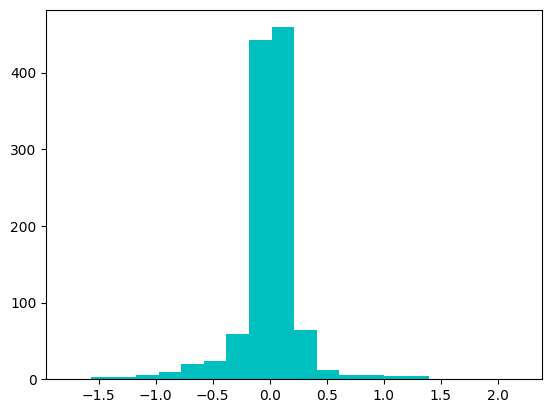

In [218]:


plt.hist(residuals, bins=20, color="c")



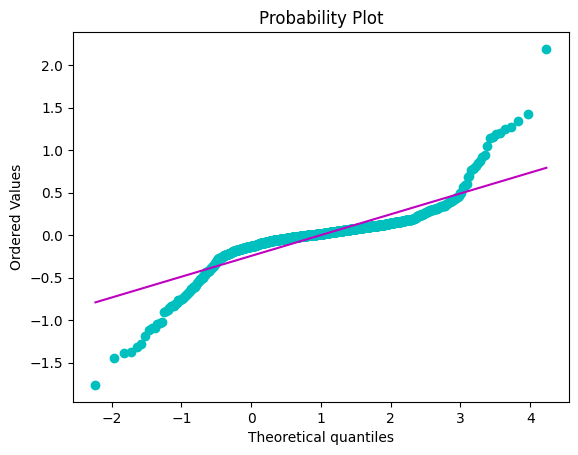

In [219]:
from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist="norm"
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

In [224]:
(1+df[["yield_avg", "yield", "water_and_emmissions"]]).apply(np.log).div(df["area_harvested"], axis=0).corr().style.background_gradient(cmap='coolwarm')

In [227]:
for climate in df["temp"].unique():
    (1+df.loc[df["temp"]==climate,["yield_avg", "yield", "water_and_emmissions"]]).apply(np.log).div(df.loc[df["temp"]==climate,"area_harvested"], axis=0).corr().style.background_gradient(cmap='coolwarm')


In [231]:
climate="Mild"
(1+df.loc[df["temp"]==climate,["yield_avg", "yield", "water_and_emmissions"]]).apply(np.log).div(df.loc[df["temp"]==climate,"area_harvested"], axis=0).corr().style.background_gradient(cmap='coolwarm')


In [176]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(1 + (df$average_per_tonne * (df$tonnes_grapes_harvested)))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                                     Df
NULL                                                                   
log(1 + df$total_emissions)                                           1
log(1 + df$water_used)                                                1
log(1 + df$total_emissions):log(1 + df$water_used):df$area_harvested  1
                                                                     Deviance
NULL                                                                         
log(1 + df$total_emissions)                                           3021.57
log(1 + df$water_used)                                                 211.34
log(1 + df$total_emissions):log(1 + df$water_used):df$area_harvested    37.34
           